In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import json

In [2]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [3]:
def dumpHistory(name, hist):
    acc, val_acc, loss, val_loss = [],[],[],[]
    if(os.path.isfile('history/' + name + '.json')):
        acc, val_acc, loss, val_loss = loadHistory(name)
    acc += hist.history['accuracy']
    val_acc += hist.history['val_accuracy']

    loss += hist.history['loss']
    val_loss += hist.history['val_loss']

    hist_dict = {
        "acc": acc,
        "val_acc": val_acc,
        "loss": loss,
        "val_loss": val_loss
    }

    with open('history/' + name + '.json', 'w', encoding='utf-8') as f:
        json.dump(hist_dict, f, ensure_ascii=False, indent=4)
    #print('DUMPED\n')

In [4]:
def loadHistory(name):
    with open('history/' + name + '.json', "r") as read_file:
        hist_dict = json.load(read_file)

    acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']
    loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']
    return acc, val_acc, loss, val_loss

In [5]:
def distplayHistory(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:
base_learning_rate = 5e-3
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
PATH = os.path.join('data_animals')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

min_LR = 1e-5
max_LR = 1e-3
step_size = 8
clr_method = "triangular"
clr = CyclicLR(mode = clr_method,base_lr=min_LR, max_lr=max_LR,step_size=step_size*BATCH_SIZE)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE, 
                                                            label_mode = 'categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = 'categorical')

Found 20938 files belonging to 10 classes.
Found 5241 files belonging to 10 classes.


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 66
Number of test batches: 16


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
preprocess_input = tf.keras.applications.xception.preprocess_input

XCEPTION

XCEPTION NO TRANSFER

In [10]:
preprocess_input_XNT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XNT = IMG_SIZE + (3,)
xception_model_XNT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XNT,
                                               include_top=False)
image_batch_XNT, label_batch_XNT = next(iter(train_dataset))
feature_batch_XNT = xception_model_XNT(image_batch_XNT)

global_average_layer_XNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XNT = global_average_layer_XNT(feature_batch_XNT)

prediction_layer_XNT = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_XNT = prediction_layer_XNT(feature_batch_average_XNT)

inputs_XNT = tf.keras.Input(shape=(160, 160, 3))
x_XNT = preprocess_input_XNT(inputs_XNT)
x_XNT = xception_model_XNT(x_XNT)
x_XNT = global_average_layer_XNT(x_XNT)
x_XNT = tf.keras.layers.Dropout(0.2)(x_XNT)
outputs_XNT = prediction_layer_XNT(x_XNT)
model_XNT = tf.keras.Model(inputs_XNT, outputs_XNT)
model_XNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XNT = "training_models/Animals_XNT.ckpt"
checkpoint_dir_XNT = os.path.dirname(checkpoint_path_XNT)
cp_callback_XNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [11]:
total_epochs_XNT = 10
history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT])
initial_epochs_XNT=total_epochs_XNT
dumpHistory('NTXceptionAnimals', history_XNT)

Epoch 1/10
328/328 [==============================] - 845s 3s/step - loss: 1.3906 - accuracy: 0.6125 - val_loss: 0.6208 - val_accuracy: 0.8653
Epoch 2/10
328/328 [==============================] - 822s 3s/step - loss: 0.5539 - accuracy: 0.8768 - val_loss: 0.3773 - val_accuracy: 0.9144
Epoch 3/10
328/328 [==============================] - 776s 2s/step - loss: 0.3394 - accuracy: 0.9139 - val_loss: 0.2732 - val_accuracy: 0.9251
Epoch 4/10
328/328 [==============================] - 808s 2s/step - loss: 0.2528 - accuracy: 0.9312 - val_loss: 0.2305 - val_accuracy: 0.9336
Epoch 5/10
328/328 [==============================] - 823s 3s/step - loss: 0.2023 - accuracy: 0.9429 - val_loss: 0.2029 - val_accuracy: 0.9369
Epoch 6/10
328/328 [==============================] - 798s 2s/step - loss: 0.1752 - accuracy: 0.9511 - val_loss: 0.1919 - val_accuracy: 0.9402
Epoch 7/10
328/328 [==============================] - 819s 2s/step - loss: 0.1491 - accuracy: 0.9574 - val_loss: 0.1809 - val_accuracy: 0.9414

In [12]:
model_XNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XNT = 10
total_epochs_XNT =  initial_epochs_XNT + add_epochs_XNT

history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=initial_epochs_XNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT, clr])
initial_epochs_XNT+=add_epochs_XNT
dumpHistory('NTXceptionAnimals', history_XNT)

Epoch 11/20
328/328 [==============================] - 833s 3s/step - loss: 0.0884 - accuracy: 0.9762 - val_loss: 0.1650 - val_accuracy: 0.9481
Epoch 12/20
328/328 [==============================] - 815s 2s/step - loss: 0.0797 - accuracy: 0.9782 - val_loss: 0.1627 - val_accuracy: 0.9497
Epoch 13/20
328/328 [==============================] - 800s 2s/step - loss: 0.0687 - accuracy: 0.9817 - val_loss: 0.1609 - val_accuracy: 0.9497
Epoch 14/20
328/328 [==============================] - 781s 2s/step - loss: 0.0625 - accuracy: 0.9843 - val_loss: 0.1635 - val_accuracy: 0.9478
Epoch 15/20
328/328 [==============================] - 780s 2s/step - loss: 0.0580 - accuracy: 0.9847 - val_loss: 0.1582 - val_accuracy: 0.9519
Epoch 16/20
328/328 [==============================] - 780s 2s/step - loss: 0.0491 - accuracy: 0.9877 - val_loss: 0.1560 - val_accuracy: 0.9502
Epoch 17/20
328/328 [==============================] - 780s 2s/step - loss: 0.0448 - accuracy: 0.9893 - val_loss: 0.1602 - val_accuracy:

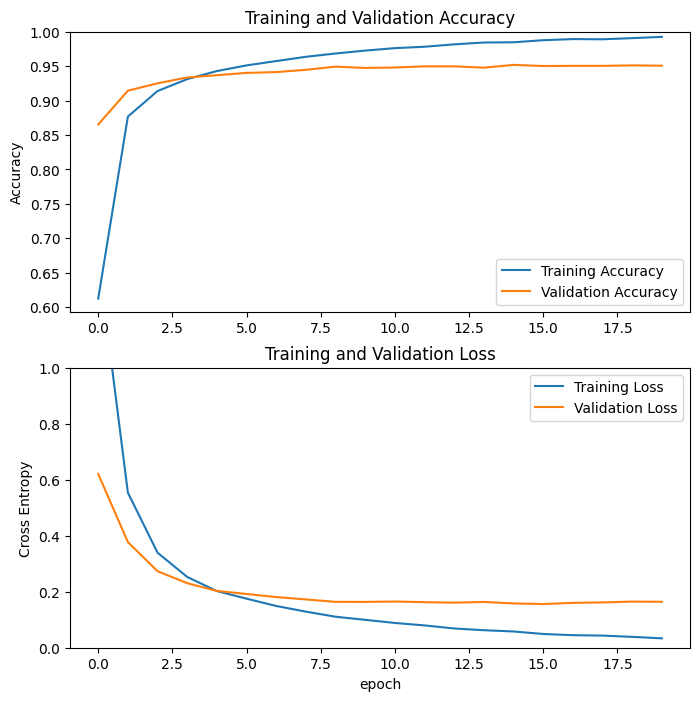

In [15]:
acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT = loadHistory('NTXceptionAnimals')
distplayHistory(acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT)

In [17]:
loss0, accuracy0 = model_XNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss0))
print("Test accuracy: {:.4f}".format(accuracy0))

16/16 [==============================] - 12s 683ms/step - loss: 0.1570 - accuracy: 0.9609
Test loss: 0.1570
Test accuracy: 0.9609


XCEPTION FAST TRANSFER

In [56]:
preprocess_input_XFT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XFT = IMG_SIZE + (3,)
xception_model_XFT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XFT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XFT.trainable = False
image_batch_XFT, label_batch_XFT = next(iter(train_dataset))
feature_batch_XFT = xception_model_XFT(image_batch_XFT)
global_average_layer_XFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XFT = global_average_layer_XFT(feature_batch_XFT)
prediction_layer_XFT = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_XFT = prediction_layer_XFT(feature_batch_average_XFT)
inputs_XFT = tf.keras.Input(shape=(160, 160, 3))
x_XFT = preprocess_input_XFT(inputs_XFT)
x_XFT = xception_model_XFT(x_XFT)
x_XFT = global_average_layer_XFT(x_XFT)
x_XFT = tf.keras.layers.Dropout(0.2)(x_XFT)
outputs_XFT = prediction_layer_XFT(x_XFT)
model_XFT = tf.keras.Model(inputs_XFT, outputs_XFT)
model_XFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XFT = "training_models/Animals_XFT.ckpt"
checkpoint_dir_XFT = os.path.dirname(checkpoint_path_XFT)
cp_callback_XFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XFT,
                                                 save_weights_only=True,
                                                 verbose=0)
'''model_XFT.summary()
print(len(model_XFT.trainable_variables))'''

'model_XFT.summary()\nprint(len(model_XFT.trainable_variables))'

In [57]:
total_epochs_XFT = 5
history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
initial_epochs_XFT=total_epochs_XFT
dumpHistory('XFTceptionAnimals', history_XFT)

Epoch 1/5
328/328 [==============================] - 273s 822ms/step - loss: 0.7766 - accuracy: 0.7945 - val_loss: 0.4064 - val_accuracy: 0.8933
Epoch 2/5
328/328 [==============================] - 269s 818ms/step - loss: 0.3582 - accuracy: 0.9062 - val_loss: 0.3158 - val_accuracy: 0.9111
Epoch 3/5
328/328 [==============================] - 269s 821ms/step - loss: 0.3002 - accuracy: 0.9187 - val_loss: 0.2772 - val_accuracy: 0.9198
Epoch 4/5
328/328 [==============================] - 269s 821ms/step - loss: 0.2683 - accuracy: 0.9240 - val_loss: 0.2658 - val_accuracy: 0.9206
Epoch 5/5
328/328 [==============================] - 269s 820ms/step - loss: 0.2517 - accuracy: 0.9278 - val_loss: 0.2484 - val_accuracy: 0.9253


In [59]:
xception_model_XFT.trainable = True
fine_tune_at_XFT = 120
for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
  layer_XFT.trainable = False
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XFT = 1
total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
dumpHistory('XFTceptionAnimals', history_XFT)
initial_epochs_XFT += fine_tune_epochs_XFT
print(len(model_XFT.trainable_variables))
for i in range (4):
  xception_model_XFT.trainable = True
  fine_tune_at_XFT -= 30
  for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
    layer_XFT.trainable = False
  model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  len(model_XFT.trainable_variables)
  print(initial_epochs_XFT)
  fine_tune_epochs_XFT = 1
  total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT


  history_XFT = model_XFT.fit(train_dataset,
                          epochs=total_epochs_XFT,
                          initial_epoch=initial_epochs_XFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_XFT])
  dumpHistory('XFTceptionAnimals', history_XFT)
  initial_epochs_XFT+=fine_tune_epochs_XFT


Epoch 6/6
328/328 [==============================] - 311s 938ms/step - loss: 0.9532 - accuracy: 0.8865 - val_loss: 0.5768 - val_accuracy: 0.9016
17
6
Epoch 7/7
328/328 [==============================] - 405s 1s/step - loss: 0.9517 - accuracy: 0.8539 - val_loss: 0.7892 - val_accuracy: 0.8793
7
Epoch 8/8
328/328 [==============================] - 494s 1s/step - loss: 0.8514 - accuracy: 0.8414 - val_loss: 0.7421 - val_accuracy: 0.8710
8
Epoch 9/9
328/328 [==============================] - 582s 2s/step - loss: 0.7669 - accuracy: 0.8371 - val_loss: 0.6697 - val_accuracy: 0.8651
9
Epoch 10/10
328/328 [==============================] - 828s 3s/step - loss: 0.6944 - accuracy: 0.8510 - val_loss: 0.6235 - val_accuracy: 0.8736


In [61]:
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XFT = 10
total_epochs_XFT =  initial_epochs_XFT + add_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT, clr])
initial_epochs_XFT+=add_epochs_XFT
dumpHistory('XFTceptionAnimals', history_XFT)

Epoch 11/20
328/328 [==============================] - 835s 3s/step - loss: 0.5511 - accuracy: 0.8795 - val_loss: 0.4247 - val_accuracy: 0.9066
Epoch 12/20
328/328 [==============================] - 824s 3s/step - loss: 0.3385 - accuracy: 0.9149 - val_loss: 0.2485 - val_accuracy: 0.9300
Epoch 13/20
328/328 [==============================] - 547s 2s/step - loss: 0.2210 - accuracy: 0.9389 - val_loss: 0.2124 - val_accuracy: 0.9367
Epoch 14/20
328/328 [==============================] - 291s 887ms/step - loss: 0.1845 - accuracy: 0.9480 - val_loss: 0.2022 - val_accuracy: 0.9393
Epoch 15/20
328/328 [==============================] - 299s 910ms/step - loss: 0.1677 - accuracy: 0.9535 - val_loss: 0.1804 - val_accuracy: 0.9445
Epoch 16/20
328/328 [==============================] - 518s 2s/step - loss: 0.1362 - accuracy: 0.9612 - val_loss: 0.1743 - val_accuracy: 0.9445
Epoch 17/20
328/328 [==============================] - 746s 2s/step - loss: 0.1120 - accuracy: 0.9703 - val_loss: 0.1724 - val_acc

In [62]:
loss1, accuracy1 = model_XFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss1))
print("Test accuracy: {:.4f}".format(accuracy1))

16/16 [==============================] - 11s 671ms/step - loss: 0.1412 - accuracy: 0.9580
Test loss: 0.1412
Test accuracy: 0.9580


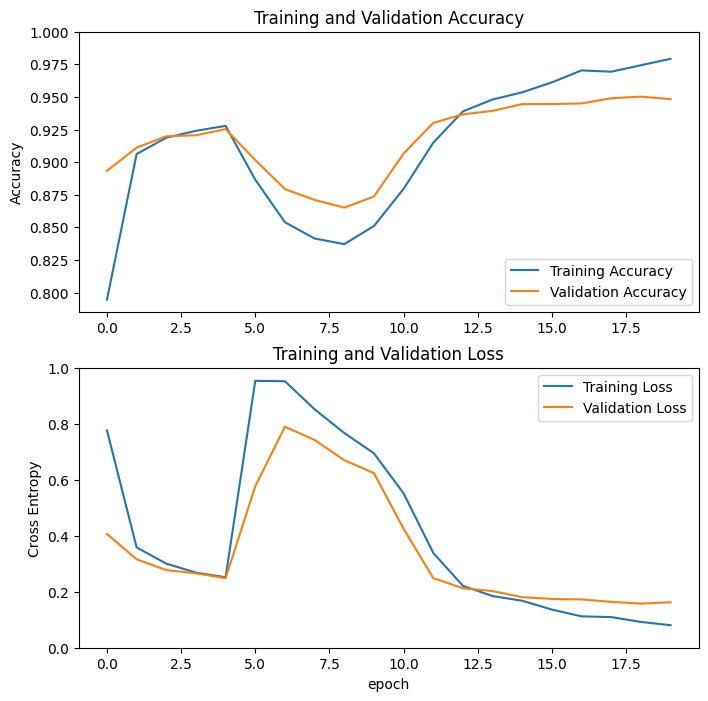

In [74]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('XFTceptionAnimals')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

XCEPTION SLOW TRANSFER

In [9]:
preprocess_input_XST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XST = IMG_SIZE + (3,)
xception_model_XST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XST.trainable = False
image_batch_XST, label_batch_XST = next(iter(train_dataset))
feature_batch_XST = xception_model_XST(image_batch_XST)
global_average_layer_XST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XST = global_average_layer_XST(feature_batch_XST)
prediction_layer_XST = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_XST = prediction_layer_XST(feature_batch_average_XST)
inputs_XST = tf.keras.Input(shape=(160, 160, 3))
x_XST = preprocess_input_XST(inputs_XST)
x_XST = xception_model_XST(x_XST)
x_XST = global_average_layer_XST(x_XST)
x_XST = tf.keras.layers.Dropout(0.2)(x_XST)
outputs_XST = prediction_layer_XST(x_XST)
model_XST = tf.keras.Model(inputs_XST, outputs_XST)
model_XST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XST = "training_models/Animals_XST.ckpt"
checkpoint_dir_XST = os.path.dirname(checkpoint_path_XST)
cp_callback_XST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XST,
                                                 save_weights_only=True,
                                                 verbose=0)
'''model_XST.summary()
print(len(model_XST.trainable_variables))'''

'model_XST.summary()\nprint(len(model_XST.trainable_variables))'

In [76]:
total_epochs_XST = 10
history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
initial_epochs_XST=total_epochs_XST
dumpHistory('XSTceptionAnimals', history_XST)

Epoch 1/10
328/328 [==============================] - 237s 709ms/step - loss: 0.7751 - accuracy: 0.7934 - val_loss: 0.3941 - val_accuracy: 0.9004
Epoch 2/10
328/328 [==============================] - 247s 751ms/step - loss: 0.3564 - accuracy: 0.9069 - val_loss: 0.3069 - val_accuracy: 0.9137
Epoch 3/10
328/328 [==============================] - 136s 411ms/step - loss: 0.3003 - accuracy: 0.9185 - val_loss: 0.2716 - val_accuracy: 0.9201
Epoch 4/10
328/328 [==============================] - 106s 322ms/step - loss: 0.2702 - accuracy: 0.9237 - val_loss: 0.2565 - val_accuracy: 0.9225
Epoch 5/10
328/328 [==============================] - 108s 328ms/step - loss: 0.2494 - accuracy: 0.9289 - val_loss: 0.2422 - val_accuracy: 0.9270
Epoch 6/10
328/328 [==============================] - 108s 327ms/step - loss: 0.2381 - accuracy: 0.9318 - val_loss: 0.2324 - val_accuracy: 0.9281
Epoch 7/10
328/328 [==============================] - 112s 340ms/step - loss: 0.2270 - accuracy: 0.9342 - val_loss: 0.2298 -

In [77]:
xception_model_XST.trainable = True
fine_tune_at_XST = 120
for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
  layer_XST.trainable = False
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XST = 2
total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
dumpHistory('XSTceptionAnimals', history_XST)
initial_epochs_XST += fine_tune_epochs_XST
for i in range (4):
  xception_model_XST.trainable = True
  fine_tune_at_XST -= 30
  for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
    layer_XST.trainable = False
  model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XST = 2
  total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST


  history_XST = model_XST.fit(train_dataset,
                          epochs=total_epochs_XST,
                          initial_epoch=initial_epochs_XST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XST])
  dumpHistory('XSTceptionAnimals', history_XST)
  initial_epochs_XST+=fine_tune_epochs_XST

Epoch 11/12
328/328 [==============================] - 128s 375ms/step - loss: 0.8368 - accuracy: 0.9052 - val_loss: 0.4935 - val_accuracy: 0.9118
Epoch 12/12
328/328 [==============================] - 121s 366ms/step - loss: 0.6884 - accuracy: 0.9128 - val_loss: 0.5957 - val_accuracy: 0.9175
17
12
Epoch 13/14
328/328 [==============================] - 161s 474ms/step - loss: 0.7791 - accuracy: 0.8805 - val_loss: 0.6674 - val_accuracy: 0.8931
Epoch 14/14
328/328 [==============================] - 159s 483ms/step - loss: 0.6681 - accuracy: 0.8920 - val_loss: 0.5925 - val_accuracy: 0.8997
14
Epoch 15/16
328/328 [==============================] - 201s 594ms/step - loss: 0.6667 - accuracy: 0.8720 - val_loss: 0.5867 - val_accuracy: 0.8928
Epoch 16/16
328/328 [==============================] - 196s 595ms/step - loss: 0.5810 - accuracy: 0.8826 - val_loss: 0.5253 - val_accuracy: 0.8968
16
Epoch 17/18
328/328 [==============================] - 243s 725ms/step - loss: 0.5805 - accuracy: 0.8696 -

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[64,5,5,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_10/xception/block14_sepconv2_act/Relu-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_413502]

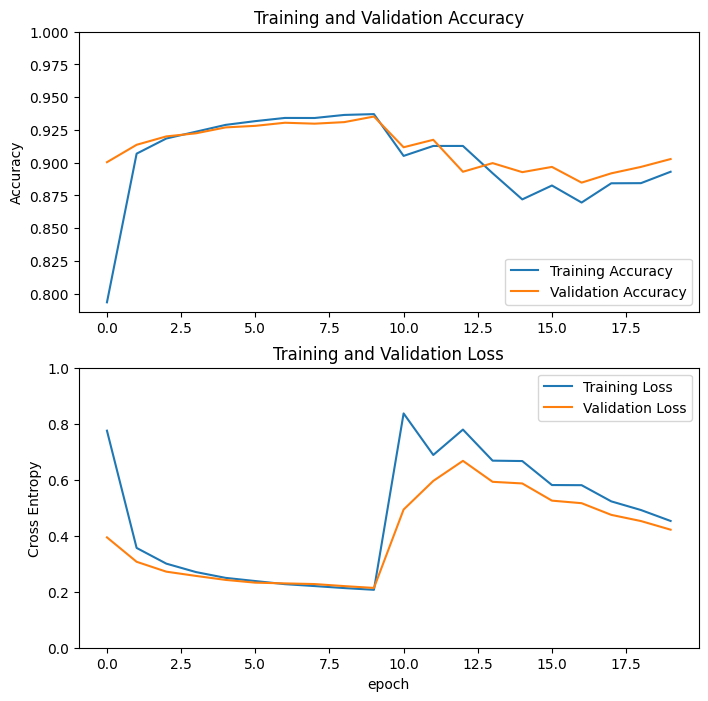

In [17]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('XSTceptionAnimals')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

In [16]:
model_XST.load_weights("training_models/Animals_XST.ckpt")
total_epochs_XST = 20
initial_epochs_XST = 18
xception_model_XST.trainable = True
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
               metrics=['accuracy'])
model_XST.summary()
history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
dumpHistory('XSTceptionAnimals', history_XST)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

NameError: name 'history_XST' is not defined

In [20]:
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XST = 5
initial_epochs_XST = total_epochs_XST
total_epochs_XST =  initial_epochs_XST + add_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST, clr])
initial_epochs_XST+=add_epochs_XST
dumpHistory('XSTceptionAnimals', history_XST)

Epoch 21/25
328/328 [==============================] - 296s 881ms/step - loss: 0.3889 - accuracy: 0.9062 - val_loss: 0.3072 - val_accuracy: 0.9203
Epoch 22/25
328/328 [==============================] - 291s 886ms/step - loss: 0.2557 - accuracy: 0.9311 - val_loss: 0.2138 - val_accuracy: 0.9355
Epoch 23/25
328/328 [==============================] - 299s 912ms/step - loss: 0.1861 - accuracy: 0.9480 - val_loss: 0.1980 - val_accuracy: 0.9395
Epoch 24/25
328/328 [==============================] - 304s 927ms/step - loss: 0.1654 - accuracy: 0.9528 - val_loss: 0.1909 - val_accuracy: 0.9402
Epoch 25/25
328/328 [==============================] - 308s 939ms/step - loss: 0.1485 - accuracy: 0.9574 - val_loss: 0.1754 - val_accuracy: 0.9440


FileNotFoundError: [Errno 2] No such file or directory: 'history/history/XSTceptionAnimals.json.json'

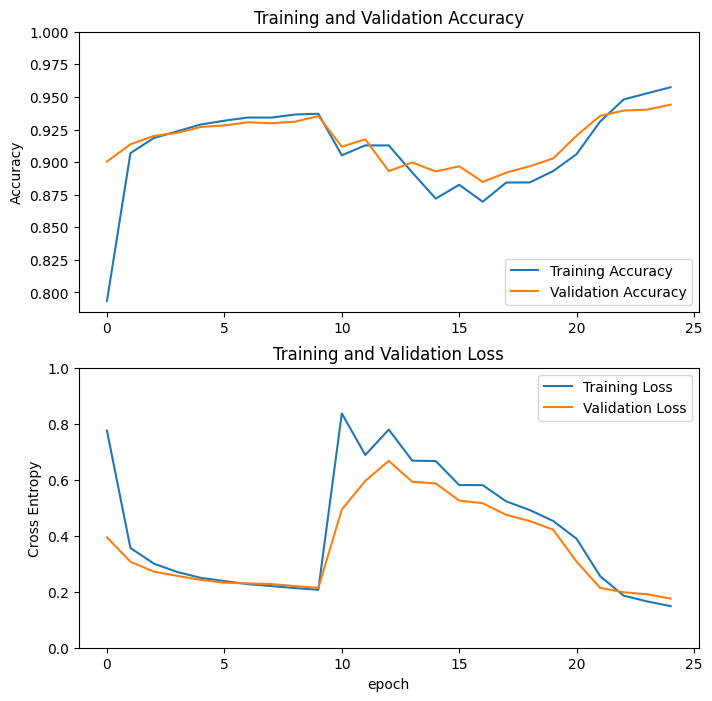

In [37]:
acc_XST, val_acc_XST, loss_XST, val_loss_XST = loadHistory('XSTceptionAnimals')
distplayHistory(acc_XST, val_acc_XST, loss_XST, val_loss_XST)

In [10]:
model_XST.load_weights("training_models/Animals_XST.ckpt")       
loss_XST, accuracy_XST = model_XST.evaluate(test_dataset)

16/16 [==============================] - 18s 720ms/step - loss: 0.1687 - accuracy: 0.9424


XCEPTION PARTICAL TRANSFER

In [13]:
preprocess_input_XPT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XPT = IMG_SIZE + (3,)
xception_model_XPT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XPT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XPT.trainable = False
image_batch_XPT, label_batch_XPT = next(iter(train_dataset))
feature_batch_XPT = xception_model_XPT(image_batch_XPT)
global_average_layer_XPT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XPT = global_average_layer_XPT(feature_batch_XPT)
prediction_layer_XPT = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_XPT = prediction_layer_XPT(feature_batch_average_XPT)
inputs_XPT = tf.keras.Input(shape=(160, 160, 3))
x_XPT = preprocess_input_XPT(inputs_XPT)
x_XPT = xception_model_XPT(x_XPT)
x_XPT = global_average_layer_XPT(x_XPT)
x_XPT = tf.keras.layers.Dropout(0.2)(x_XPT)
outputs_XPT = prediction_layer_XPT(x_XPT)
model_XPT = tf.keras.Model(inputs_XPT, outputs_XPT)
model_XPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XPT = "training_models/Animals_XPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)

In [14]:
total_epochs_XPT = 20
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT])
initial_epochs_XPT=total_epochs_XPT
dumpHistory('XPTceptionAnimals', history_XPT)

Epoch 1/20
328/328 [==============================] - 296s 882ms/step - loss: 0.7487 - accuracy: 0.7976 - val_loss: 0.3899 - val_accuracy: 0.9049
Epoch 2/20
328/328 [==============================] - 283s 861ms/step - loss: 0.3577 - accuracy: 0.9042 - val_loss: 0.3036 - val_accuracy: 0.9182
Epoch 3/20
328/328 [==============================] - 284s 864ms/step - loss: 0.2983 - accuracy: 0.9168 - val_loss: 0.2732 - val_accuracy: 0.9225
Epoch 4/20
328/328 [==============================] - 284s 865ms/step - loss: 0.2709 - accuracy: 0.9221 - val_loss: 0.2575 - val_accuracy: 0.9248
Epoch 5/20
328/328 [==============================] - 284s 866ms/step - loss: 0.2516 - accuracy: 0.9276 - val_loss: 0.2423 - val_accuracy: 0.9272
Epoch 6/20
328/328 [==============================] - 275s 837ms/step - loss: 0.2399 - accuracy: 0.9291 - val_loss: 0.2365 - val_accuracy: 0.9286
Epoch 7/20
328/328 [==============================] - 281s 855ms/step - loss: 0.2302 - accuracy: 0.9305 - val_loss: 0.2280 -

In [18]:
checkpoint_path_XPT = "training_models/Animals_XFPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)
model_XPT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
total_epochs_XPT = 40
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=initial_epochs_XPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT, clr])
dumpHistory('XPTceptionAnimals', history_XPT)

Epoch 21/40
328/328 [==============================] - 288s 866ms/step - loss: 0.1740 - accuracy: 0.9481 - val_loss: 0.2024 - val_accuracy: 0.9343
Epoch 22/40
328/328 [==============================] - 283s 862ms/step - loss: 0.1732 - accuracy: 0.9471 - val_loss: 0.1993 - val_accuracy: 0.9341
Epoch 23/40
328/328 [==============================] - 283s 863ms/step - loss: 0.1729 - accuracy: 0.9482 - val_loss: 0.1953 - val_accuracy: 0.9353
Epoch 24/40
328/328 [==============================] - 283s 862ms/step - loss: 0.1722 - accuracy: 0.9489 - val_loss: 0.1948 - val_accuracy: 0.9350
Epoch 25/40
328/328 [==============================] - 283s 864ms/step - loss: 0.1740 - accuracy: 0.9462 - val_loss: 0.1952 - val_accuracy: 0.9360
Epoch 26/40
328/328 [==============================] - 283s 861ms/step - loss: 0.1731 - accuracy: 0.9467 - val_loss: 0.1985 - val_accuracy: 0.9350
Epoch 27/40
328/328 [==============================] - 282s 858ms/step - loss: 0.1719 - accuracy: 0.9465 - val_loss: 0

In [20]:
loss_XPT, accuracy_XPT = model_XPT.evaluate(test_dataset)

16/16 [==============================] - 12s 726ms/step - loss: 0.2074 - accuracy: 0.9385


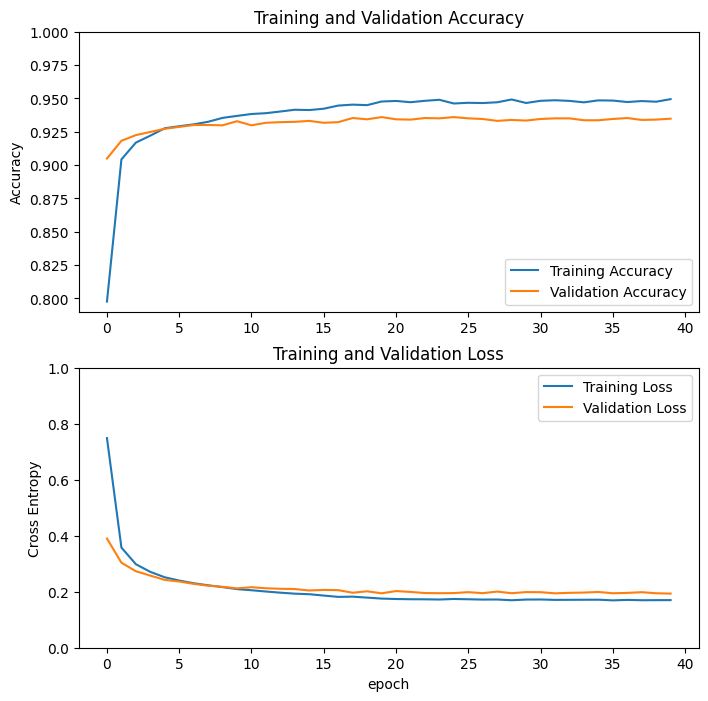

In [21]:
acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT = loadHistory('XPTceptionAnimals')
distplayHistory(acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT)

XCEPTOION VERY SLOW TRANSFER 

In [11]:
preprocess_input_XVST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XVST = IMG_SIZE + (3,)
xception_model_XVST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XVST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XVST.trainable = False
image_batch_XVST, label_batch_XVST = next(iter(train_dataset))
feature_batch_XVST = xception_model_XVST(image_batch_XVST)
global_average_layer_XVST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XVST = global_average_layer_XVST(feature_batch_XVST)
prediction_layer_XVST = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_XVST = prediction_layer_XVST(feature_batch_average_XVST)
inputs_XVST = tf.keras.Input(shape=(160, 160, 3))
x_XVST = preprocess_input_XVST(inputs_XVST)
x_XVST = xception_model_XVST(x_XVST)
x_XVST = global_average_layer_XVST(x_XVST)
x_XVST = tf.keras.layers.Dropout(0.2)(x_XVST)
outputs_XVST = prediction_layer_XVST(x_XVST)
model_XVST = tf.keras.Model(inputs_XVST, outputs_XVST)
model_XVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XVST = "training_models/Animals_XVST.ckpt"
checkpoint_dir_XVST = os.path.dirname(checkpoint_path_XVST)
cp_callback_XVST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XVST,
                                                 save_weights_only=True,
                                                 verbose=0)


KeyboardInterrupt: 

In [26]:
print(len(xception_model_XVST.trainable_variables))

154


In [32]:
model_XVST.load_weights("training_models/Animals_XPT.ckpt")
total_epochs_XVST = 30
initial_epochs_XVST = 20
xception_model_XVST.trainable = True
fine_tune_at_XVST = 144
for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
  layer_XVST.trainable = False
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XVST = 1
total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST])
dumpHistory('XVSTceptionAnimals', history_XVST)
initial_epochs_XVST += fine_tune_epochs_XVST
for i in range (9):
  xception_model_XVST.trainable = True
  fine_tune_at_XVST -= 16
  for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
    layer_XVST.trainable = False
  model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XVST = 1
  total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST


  history_XVST = model_XVST.fit(train_dataset,
                          epochs=total_epochs_XVST,
                          initial_epoch=initial_epochs_XVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XVST])
  dumpHistory('XVSTceptionAnimals', history_XVST)
  initial_epochs_XVST+=fine_tune_epochs_XVST

Epoch 21/21
328/328 [==============================] - 287s 861ms/step - loss: 0.1720 - accuracy: 0.9476 - val_loss: 0.1974 - val_accuracy: 0.9350
Epoch 22/22
328/328 [==============================] - 302s 910ms/step - loss: 0.3654 - accuracy: 0.9408 - val_loss: 0.3406 - val_accuracy: 0.9322
Epoch 23/23
328/328 [==============================] - 347s 1s/step - loss: 0.7567 - accuracy: 0.9108 - val_loss: 0.4244 - val_accuracy: 0.9241
Epoch 24/24
328/328 [==============================] - 394s 1s/step - loss: 0.7216 - accuracy: 0.8977 - val_loss: 0.5920 - val_accuracy: 0.9080
Epoch 25/25
328/328 [==============================] - 449s 1s/step - loss: 0.6974 - accuracy: 0.8851 - val_loss: 0.6234 - val_accuracy: 0.8999
Epoch 26/26
328/328 [==============================] - 485s 1s/step - loss: 0.6185 - accuracy: 0.8854 - val_loss: 0.5489 - val_accuracy: 0.9004
Epoch 27/27
328/328 [==============================] - 534s 2s/step - loss: 0.5741 - accuracy: 0.8777 - val_loss: 0.4955 - val_acc

In [33]:
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XVST = 5
initial_epochs_XVST = total_epochs_XVST
total_epochs_XVST =  initial_epochs_XVST + add_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST, clr])
initial_epochs_XVST+=add_epochs_XVST
dumpHistory('XVSTceptionAnimals', history_XVST)

Epoch 31/35
328/328 [==============================] - 849s 3s/step - loss: 0.4070 - accuracy: 0.9021 - val_loss: 0.3751 - val_accuracy: 0.9085
Epoch 32/35
328/328 [==============================] - 844s 3s/step - loss: 0.3770 - accuracy: 0.9078 - val_loss: 0.3656 - val_accuracy: 0.9101
Epoch 33/35
328/328 [==============================] - 832s 3s/step - loss: 0.3672 - accuracy: 0.9112 - val_loss: 0.3547 - val_accuracy: 0.9127
Epoch 34/35
328/328 [==============================] - 817s 2s/step - loss: 0.3386 - accuracy: 0.9164 - val_loss: 0.3257 - val_accuracy: 0.9172
Epoch 35/35
328/328 [==============================] - 836s 3s/step - loss: 0.3197 - accuracy: 0.9169 - val_loss: 0.3141 - val_accuracy: 0.9187


16/16 [==============================] - 12s 725ms/step - loss: 0.3119 - accuracy: 0.9121


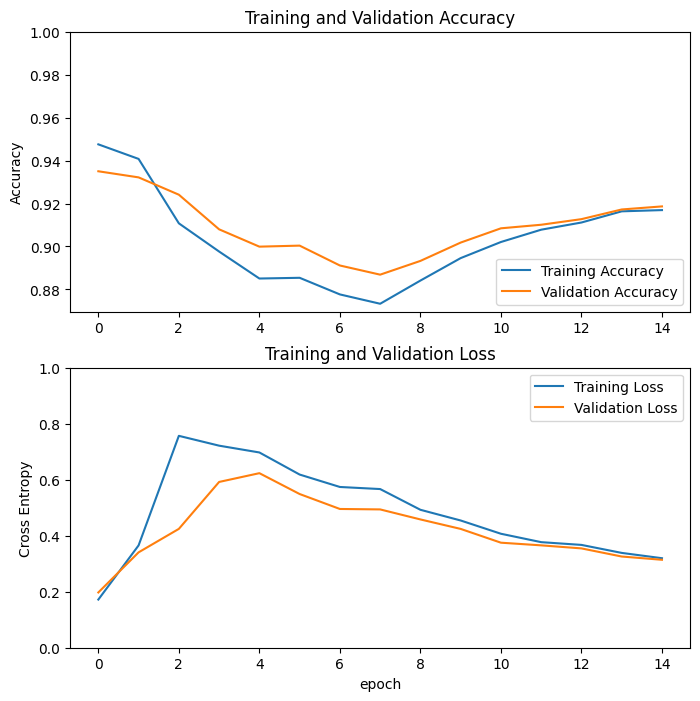

In [34]:
loss_XVST, accuracy_XVST = model_XVST.evaluate(test_dataset)
acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST = loadHistory('XVSTceptionAnimals')
distplayHistory(acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST)

VGG-16

VGG-16 NO TRANSFER

In [12]:
preprocess_input_VNT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VNT = IMG_SIZE + (3,)
xception_model_VNT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VNT,
                                               include_top=False)
image_batch_VNT, label_batch_VNT = next(iter(train_dataset))
feature_batch_VNT = xception_model_VNT(image_batch_VNT)

global_average_layer_VNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VNT = global_average_layer_VNT(feature_batch_VNT)

fc1_layer_VNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VNT = fc1_layer_VNT(feature_batch_average_VNT)

fc2_layer_VNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VNT = fc2_layer_VNT(fc1_batch_VNT)

prediction_layer_VNT = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_VNT = prediction_layer_VNT(feature_batch_average_VNT)

inputs_VNT = tf.keras.Input(shape=(160, 160, 3))
x_VNT = preprocess_input_VNT(inputs_VNT)
x_VNT = xception_model_VNT(x_VNT)
x_VNT = global_average_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc1_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc2_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
outputs_VNT = prediction_layer_VNT(x_VNT)
model_VNT = tf.keras.Model(inputs_VNT, outputs_VNT)
model_VNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VNT = "training_models/Animals_VNT.ckpt"
checkpoint_dir_VNT = os.path.dirname(checkpoint_path_VNT)
cp_callback_VNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VNT,
                                                 save_weights_only=True,
                                                 verbose=0)


KeyboardInterrupt: 

In [12]:
total_epochs_VNT = 10
history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT])
initial_epochs_VNT=total_epochs_VNT
dumpHistory('VNTvgg16Animals', history_VNT)

Epoch 1/10
328/328 [==============================] - 727s 2s/step - loss: 1.8584 - accuracy: 0.3574 - val_loss: 1.4053 - val_accuracy: 0.5383
Epoch 2/10
328/328 [==============================] - 654s 2s/step - loss: 0.7566 - accuracy: 0.7489 - val_loss: 0.9821 - val_accuracy: 0.7071
Epoch 3/10
328/328 [==============================] - 692s 2s/step - loss: 0.4001 - accuracy: 0.8740 - val_loss: 2.1524 - val_accuracy: 0.6540
Epoch 4/10
328/328 [==============================] - 666s 2s/step - loss: 0.2732 - accuracy: 0.9168 - val_loss: 0.2454 - val_accuracy: 0.9265
Epoch 5/10
328/328 [==============================] - 646s 2s/step - loss: 0.1805 - accuracy: 0.9442 - val_loss: 0.2040 - val_accuracy: 0.9374
Epoch 6/10
328/328 [==============================] - 647s 2s/step - loss: 0.1456 - accuracy: 0.9542 - val_loss: 0.2520 - val_accuracy: 0.9338
Epoch 7/10
328/328 [==============================] - 647s 2s/step - loss: 0.1720 - accuracy: 0.9497 - val_loss: 0.2329 - val_accuracy: 0.9343

In [13]:
model_VNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VNT = 10
total_epochs_VNT =  initial_epochs_VNT + add_epochs_VNT

history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=initial_epochs_VNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT, clr])
initial_epochs_VNT+=add_epochs_VNT
dumpHistory('VNTvgg16Animals', history_VNT)

Epoch 11/20
328/328 [==============================] - 696s 2s/step - loss: 0.0332 - accuracy: 0.9905 - val_loss: 0.1935 - val_accuracy: 0.9519
Epoch 12/20
328/328 [==============================] - 685s 2s/step - loss: 0.0228 - accuracy: 0.9940 - val_loss: 0.2058 - val_accuracy: 0.9552
Epoch 13/20
328/328 [==============================] - 689s 2s/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.2059 - val_accuracy: 0.9549
Epoch 14/20
328/328 [==============================] - 647s 2s/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.2069 - val_accuracy: 0.9549
Epoch 15/20
328/328 [==============================] - 647s 2s/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.2164 - val_accuracy: 0.9559
Epoch 16/20
328/328 [==============================] - 647s 2s/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.2262 - val_accuracy: 0.9576
Epoch 17/20
328/328 [==============================] - 647s 2s/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.2209 - val_accuracy:

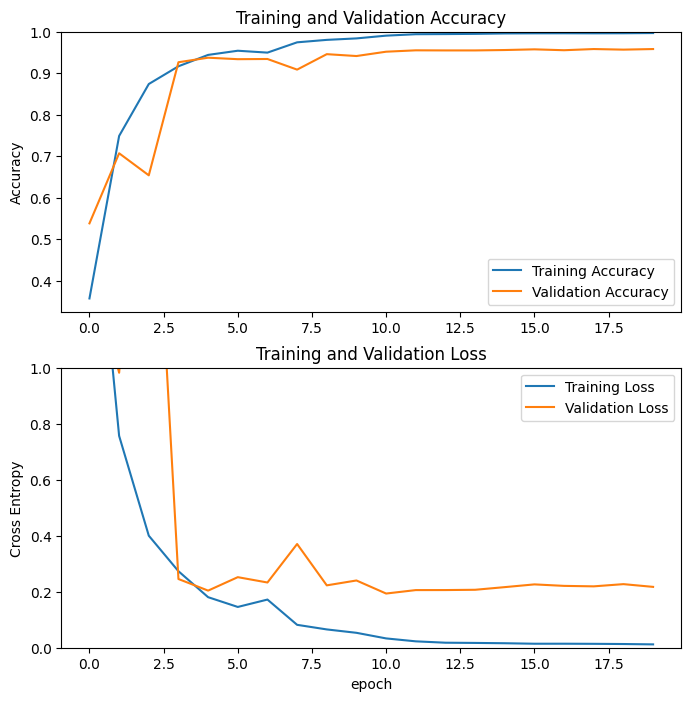

In [14]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('VNTvgg16Animals')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

In [15]:
loss4, accuracy4 = model_VNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss4))
print("Test accuracy: {:.4f}".format(accuracy4))

16/16 [==============================] - 10s 596ms/step - loss: 0.1871 - accuracy: 0.9648
Test loss: 0.1871
Test accuracy: 0.9648


VGG16 FAST TRANSFER

In [24]:
preprocess_input_VFT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VFT = IMG_SIZE + (3,)
vgg16_model_VFT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VFT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VFT.trainable = False
image_batch_VFT, label_batch_VFT = next(iter(train_dataset))
feature_batch_VFT = vgg16_model_VFT(image_batch_VFT)

global_average_layer_VFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VFT = global_average_layer_VFT(feature_batch_VFT)

fc1_layer_VFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VFT = fc1_layer_VFT(feature_batch_average_VFT)

fc2_layer_VFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VFT = fc2_layer_VFT(fc1_batch_VFT)

prediction_layer_VFT = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_VFT = prediction_layer_VFT(feature_batch_average_VFT)

inputs_VFT = tf.keras.Input(shape=(160, 160, 3))
x_VFT = preprocess_input_VFT(inputs_VFT)
x_VFT = vgg16_model_VFT(x_VFT)
x_VFT = global_average_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc1_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc2_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
outputs_VFT = prediction_layer_VFT(x_VFT)
model_VFT = tf.keras.Model(inputs_VFT, outputs_VFT)
model_VFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VFT = "training_models/Animals_VFT.ckpt"
checkpoint_dir_VFT = os.path.dirname(checkpoint_path_VFT)
cp_callback_VFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [25]:
total_epochs_VFT = 5
history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
initial_epochs_VFT=total_epochs_VFT
dumpHistory('VFTvgg16Animals', history_VFT)

Epoch 1/5
328/328 [==============================] - 236s 714ms/step - loss: 1.1711 - accuracy: 0.7527 - val_loss: 0.2890 - val_accuracy: 0.9108
Epoch 2/5
328/328 [==============================] - 234s 711ms/step - loss: 0.5347 - accuracy: 0.8412 - val_loss: 0.2518 - val_accuracy: 0.9194
Epoch 3/5
328/328 [==============================] - 234s 711ms/step - loss: 0.4434 - accuracy: 0.8615 - val_loss: 0.2528 - val_accuracy: 0.9208
Epoch 4/5
328/328 [==============================] - 234s 712ms/step - loss: 0.4040 - accuracy: 0.8698 - val_loss: 0.2559 - val_accuracy: 0.9194
Epoch 5/5
328/328 [==============================] - 220s 669ms/step - loss: 0.3665 - accuracy: 0.8823 - val_loss: 0.2241 - val_accuracy: 0.9291
DUMPED



In [26]:
vgg16_model_VFT.trainable = True
fine_tune_at_VFT = 16
for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
  layer_VFT.trainable = False
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VFT = 1
total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
dumpHistory('VFTvgg16Animals', history_VFT)
initial_epochs_VFT += fine_tune_epochs_VFT
print(len(model_VFT.trainable_variables))
for i in range (4):
  vgg16_model_VFT.trainable = True
  fine_tune_at_VFT -= 4
  for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
    layer_VFT.trainable = False
  model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VFT = 1
  total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT


  history_VFT = model_VFT.fit(train_dataset,
                          epochs=total_epochs_VFT,
                          initial_epoch=initial_epochs_VFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_VFT])
  dumpHistory('VFTvgg16Animals', history_VFT)
  initial_epochs_VFT+=fine_tune_epochs_VFT


Epoch 6/6
328/328 [==============================] - 248s 752ms/step - loss: 0.3306 - accuracy: 0.8910 - val_loss: 0.2156 - val_accuracy: 0.9336
DUMPED

10
Epoch 7/7
328/328 [==============================] - 316s 960ms/step - loss: 0.2865 - accuracy: 0.9061 - val_loss: 0.1986 - val_accuracy: 0.9372
DUMPED

Epoch 8/8
328/328 [==============================] - 405s 1s/step - loss: 0.2644 - accuracy: 0.9153 - val_loss: 0.1882 - val_accuracy: 0.9440
DUMPED

Epoch 9/9
328/328 [==============================] - 551s 2s/step - loss: 0.2282 - accuracy: 0.9264 - val_loss: 0.1852 - val_accuracy: 0.9440
DUMPED

Epoch 10/10
328/328 [==============================] - 686s 2s/step - loss: 0.2056 - accuracy: 0.9335 - val_loss: 0.1688 - val_accuracy: 0.9483
DUMPED



In [27]:
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VFT = 10
total_epochs_VFT =  initial_epochs_VFT + add_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT, clr])
initial_epochs_VFT+=add_epochs_VFT
dumpHistory('VFTvgg16Animals', history_VFT)

Epoch 11/20
328/328 [==============================] - 686s 2s/step - loss: 0.1885 - accuracy: 0.9376 - val_loss: 0.2162 - val_accuracy: 0.9315
Epoch 12/20
328/328 [==============================] - 686s 2s/step - loss: 0.1786 - accuracy: 0.9429 - val_loss: 0.1594 - val_accuracy: 0.9509
Epoch 13/20
328/328 [==============================] - 666s 2s/step - loss: 0.1560 - accuracy: 0.9486 - val_loss: 0.1646 - val_accuracy: 0.9481
Epoch 14/20
328/328 [==============================] - 646s 2s/step - loss: 0.1496 - accuracy: 0.9501 - val_loss: 0.1611 - val_accuracy: 0.9493
Epoch 15/20
328/328 [==============================] - 646s 2s/step - loss: 0.1412 - accuracy: 0.9546 - val_loss: 0.1583 - val_accuracy: 0.9514
Epoch 16/20
328/328 [==============================] - 647s 2s/step - loss: 0.1237 - accuracy: 0.9608 - val_loss: 0.1574 - val_accuracy: 0.9516
Epoch 17/20
328/328 [==============================] - 646s 2s/step - loss: 0.1233 - accuracy: 0.9604 - val_loss: 0.1588 - val_accuracy:

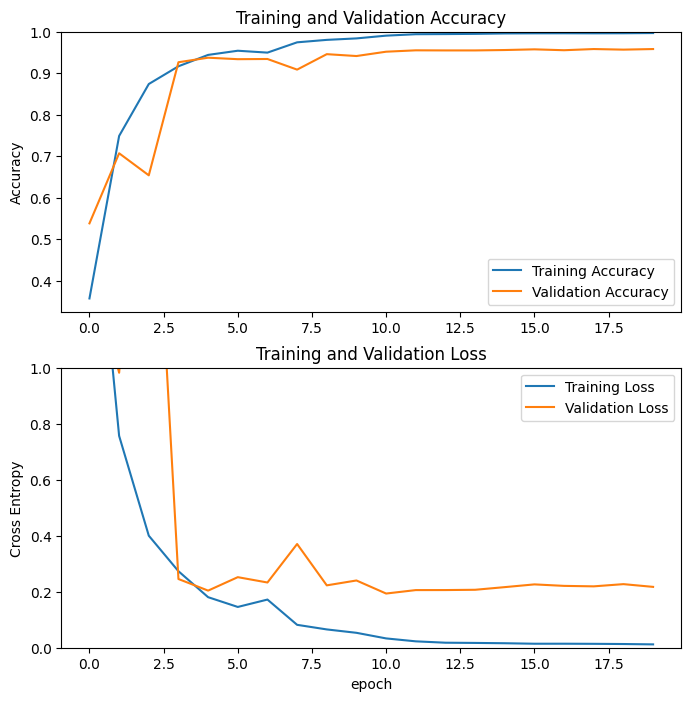

16/16 [==============================] - 10s 585ms/step - loss: 0.1187 - accuracy: 0.9600
Test loss: 0.1187
Test accuracy: 0.9600


In [28]:
acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT = loadHistory('VNTvgg16Animals')
distplayHistory(acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT)
loss5, accuracy5 = model_VFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss5))
print("Test accuracy: {:.4f}".format(accuracy5))

VGG16 SLOW TRANSFER

In [11]:
preprocess_input_VST = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VST = IMG_SIZE + (3,)
vgg16_model_VST = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VST.trainable = False
image_batch_VST, label_batch_VST = next(iter(train_dataset))
feature_batch_VST = vgg16_model_VST(image_batch_VST)

global_average_layer_VST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VST = global_average_layer_VST(feature_batch_VST)

fc1_layer_VST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VST = fc1_layer_VST(feature_batch_average_VST)

fc2_layer_VST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VST = fc2_layer_VST(fc1_batch_VST)

prediction_layer_VST = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_VST = prediction_layer_VST(feature_batch_average_VST)

inputs_VST = tf.keras.Input(shape=(160, 160, 3))
x_VST = preprocess_input_VST(inputs_VST)
x_VST = vgg16_model_VST(x_VST)
x_VST = global_average_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc1_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc2_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
outputs_VST = prediction_layer_VST(x_VST)
model_VST = tf.keras.Model(inputs_VST, outputs_VST)
model_VST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VST = "training_models/Animals_VST.ckpt"
checkpoint_dir_VST = os.path.dirname(checkpoint_path_VST)
cp_callback_VST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [30]:
total_epochs_VST = 10
history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
initial_epochs_VST=total_epochs_VST
dumpHistory('VSTvgg16Animals', history_VST)

Epoch 1/10
328/328 [==============================] - 232s 704ms/step - loss: 1.1583 - accuracy: 0.7524 - val_loss: 0.3806 - val_accuracy: 0.8878
Epoch 2/10
328/328 [==============================] - 233s 708ms/step - loss: 0.5543 - accuracy: 0.8358 - val_loss: 0.2684 - val_accuracy: 0.9144
Epoch 3/10
328/328 [==============================] - 232s 705ms/step - loss: 0.4481 - accuracy: 0.8584 - val_loss: 0.2829 - val_accuracy: 0.9125
Epoch 4/10
328/328 [==============================] - 232s 705ms/step - loss: 0.4005 - accuracy: 0.8712 - val_loss: 0.2467 - val_accuracy: 0.9196
Epoch 5/10
328/328 [==============================] - 231s 704ms/step - loss: 0.3675 - accuracy: 0.8814 - val_loss: 0.2281 - val_accuracy: 0.9300
Epoch 6/10
328/328 [==============================] - 229s 696ms/step - loss: 0.3456 - accuracy: 0.8879 - val_loss: 0.2325 - val_accuracy: 0.9251
Epoch 7/10
328/328 [==============================] - 225s 686ms/step - loss: 0.3268 - accuracy: 0.8946 - val_loss: 0.2222 -

In [31]:
vgg16_model_VST.trainable = True
fine_tune_at_VST = 16
for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
  layer_VST.trainable = False
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VST = 2
total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
dumpHistory('VSTvgg16Animals', history_VST)
initial_epochs_VST += fine_tune_epochs_VST
print(len(model_VST.trainable_variables))
for i in range (4):
  vgg16_model_VST.trainable = True
  fine_tune_at_VST -= 4
  for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
    layer_VST.trainable = False
  model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VST = 2
  total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST


  history_VST = model_VST.fit(train_dataset,
                          epochs=total_epochs_VST,
                          initial_epoch=initial_epochs_VST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VST])
  dumpHistory('VSTvgg16Animals', history_VST)
  initial_epochs_VST+=fine_tune_epochs_VST


Epoch 11/12
328/328 [==============================] - 248s 753ms/step - loss: 0.2718 - accuracy: 0.9097 - val_loss: 0.2020 - val_accuracy: 0.9362
Epoch 12/12
328/328 [==============================] - 253s 770ms/step - loss: 0.2540 - accuracy: 0.9171 - val_loss: 0.2022 - val_accuracy: 0.9348
DUMPED

10
Epoch 13/14
328/328 [==============================] - 315s 957ms/step - loss: 0.2356 - accuracy: 0.9238 - val_loss: 0.1916 - val_accuracy: 0.9405
Epoch 14/14
328/328 [==============================] - 314s 956ms/step - loss: 0.2070 - accuracy: 0.9320 - val_loss: 0.1734 - val_accuracy: 0.9436
DUMPED

Epoch 15/16
328/328 [==============================] - 388s 1s/step - loss: 0.1931 - accuracy: 0.9360 - val_loss: 0.1821 - val_accuracy: 0.9424
Epoch 16/16
328/328 [==============================] - 403s 1s/step - loss: 0.1786 - accuracy: 0.9414 - val_loss: 0.1716 - val_accuracy: 0.9464
DUMPED

Epoch 17/18
328/328 [==============================] - 544s 2s/step - loss: 0.1653 - accuracy: 0.

In [32]:
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VST = 5
total_epochs_VST =  initial_epochs_VST + add_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST, clr])
initial_epochs_VST+=add_epochs_VST
dumpHistory('VSTvgg16Animals', history_VST)

Epoch 21/25
328/328 [==============================] - 672s 2s/step - loss: 0.1267 - accuracy: 0.9580 - val_loss: 0.1519 - val_accuracy: 0.9514
Epoch 22/25
328/328 [==============================] - 687s 2s/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.1512 - val_accuracy: 0.9516
Epoch 23/25
328/328 [==============================] - 688s 2s/step - loss: 0.1054 - accuracy: 0.9665 - val_loss: 0.1474 - val_accuracy: 0.9526
Epoch 24/25
328/328 [==============================] - 689s 2s/step - loss: 0.1073 - accuracy: 0.9638 - val_loss: 0.1524 - val_accuracy: 0.9533
Epoch 25/25
328/328 [==============================] - 683s 2s/step - loss: 0.0951 - accuracy: 0.9689 - val_loss: 0.1434 - val_accuracy: 0.9545
DUMPED



16/16 [==============================] - 29s 582ms/step - loss: 0.1618 - accuracy: 0.9531


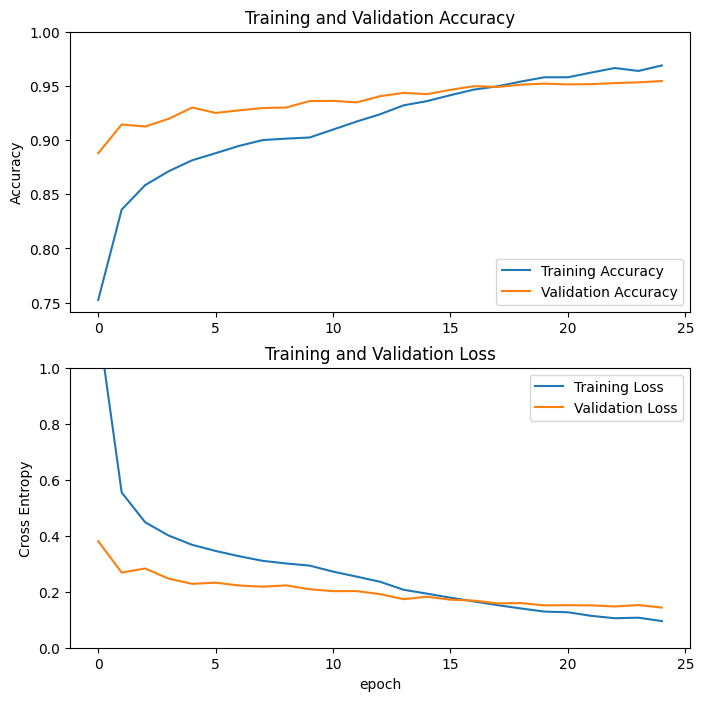

In [12]:
model_VST.load_weights("training_models/Animals_VST.ckpt")
loss_VST, accuracy_VST = model_VST.evaluate(test_dataset)
acc_VST, val_acc_VST, loss_VST, val_loss_VST = loadHistory('VSTvgg16Animals')
distplayHistory(acc_VST, val_acc_VST, loss_VST, val_loss_VST)

VGG PARTICAL TRANSFER

In [37]:
preprocess_input_VPT= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VPT= IMG_SIZE + (3,)
vgg16_model_VPT= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VPT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VPT.trainable = False
image_batch_VPT, label_batch_VPT= next(iter(train_dataset))
feature_batch_VPT= vgg16_model_VPT(image_batch_VPT)

global_average_layer_VPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VPT= global_average_layer_VPT(feature_batch_VPT)

fc1_layer_VPT= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VPT= fc1_layer_VPT(feature_batch_average_VPT)

fc2_layer_VPT= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VPT= fc2_layer_VPT(fc1_batch_VPT)

prediction_layer_VPT= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_VPT= prediction_layer_VPT(feature_batch_average_VPT)

inputs_VPT= tf.keras.Input(shape=(160, 160, 3))
x_VPT= preprocess_input_VPT(inputs_VPT)
x_VPT= vgg16_model_VPT(x_VPT)
x_VPT= global_average_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc1_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc2_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
outputs_VPT= prediction_layer_VPT(x_VPT)
model_VPT= tf.keras.Model(inputs_VPT, outputs_VPT)
model_VPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VPT= "training_models/Animals_VPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [14]:
total_epochs_VPT = 20
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT])
initial_epochs_VPT=total_epochs_VPT
dumpHistory('VPTvgg16Animals', history_VPT)

Epoch 1/20
328/328 [==============================] - 277s 784ms/step - loss: 1.1933 - accuracy: 0.7515 - val_loss: 0.3167 - val_accuracy: 0.9025
Epoch 2/20
328/328 [==============================] - 203s 619ms/step - loss: 0.5531 - accuracy: 0.8391 - val_loss: 0.2688 - val_accuracy: 0.9170
Epoch 3/20
328/328 [==============================] - 230s 700ms/step - loss: 0.4441 - accuracy: 0.8641 - val_loss: 0.2698 - val_accuracy: 0.9149
Epoch 4/20
328/328 [==============================] - 230s 699ms/step - loss: 0.3910 - accuracy: 0.8758 - val_loss: 0.2402 - val_accuracy: 0.9279
Epoch 5/20
328/328 [==============================] - 229s 698ms/step - loss: 0.3673 - accuracy: 0.8827 - val_loss: 0.2389 - val_accuracy: 0.9258
Epoch 6/20
328/328 [==============================] - 223s 680ms/step - loss: 0.3406 - accuracy: 0.8923 - val_loss: 0.2166 - val_accuracy: 0.9350
Epoch 7/20
328/328 [==============================] - 216s 657ms/step - loss: 0.3260 - accuracy: 0.8950 - val_loss: 0.2140 -

In [16]:
checkpoint_path_VPT= "training_models/Animals_VFPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_VPT = 40
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=initial_epochs_VPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT, clr])
dumpHistory('VPTvgg16Animals', history_VPT)

Epoch 21/40
328/328 [==============================] - 234s 713ms/step - loss: 0.2250 - accuracy: 0.9244 - val_loss: 0.1896 - val_accuracy: 0.9400
Epoch 22/40
328/328 [==============================] - 231s 705ms/step - loss: 0.2208 - accuracy: 0.9273 - val_loss: 0.1923 - val_accuracy: 0.9405
Epoch 23/40
328/328 [==============================] - 231s 705ms/step - loss: 0.2153 - accuracy: 0.9279 - val_loss: 0.1849 - val_accuracy: 0.9445
Epoch 24/40
328/328 [==============================] - 232s 705ms/step - loss: 0.2162 - accuracy: 0.9268 - val_loss: 0.1854 - val_accuracy: 0.9421
Epoch 25/40
328/328 [==============================] - 220s 670ms/step - loss: 0.2139 - accuracy: 0.9269 - val_loss: 0.1889 - val_accuracy: 0.9426
Epoch 26/40
328/328 [==============================] - 218s 664ms/step - loss: 0.2116 - accuracy: 0.9284 - val_loss: 0.1916 - val_accuracy: 0.9407
Epoch 27/40
328/328 [==============================] - 218s 664ms/step - loss: 0.2184 - accuracy: 0.9270 - val_loss: 0

16/16 [==============================] - 10s 583ms/step - loss: 0.2195 - accuracy: 0.9287


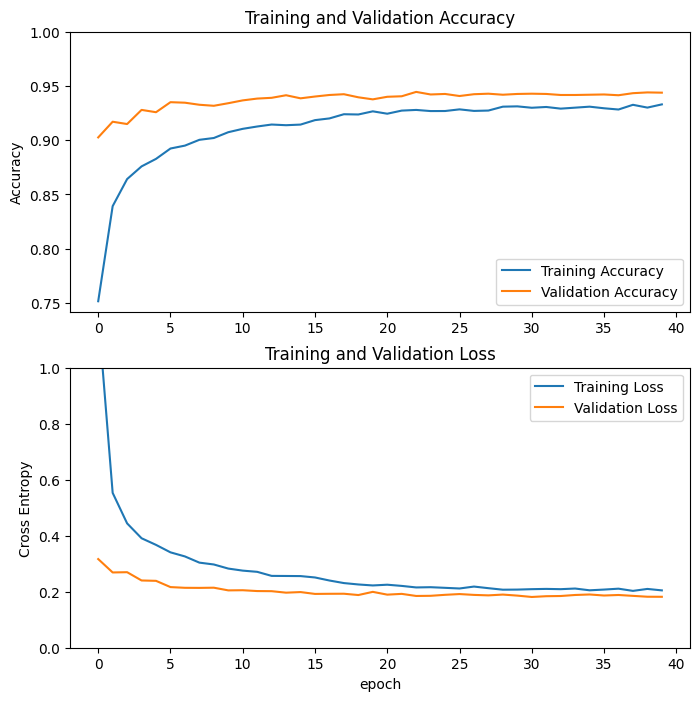

In [38]:
model_VPT.load_weights("training_models/Animals_VPT.ckpt")
loss_VPT, accuracy_VPT = model_VPT.evaluate(test_dataset)
acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT = loadHistory('VPTvgg16Animals')
distplayHistory(acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT)

VGG16 VERY SLOW TRANSFER

In [40]:
preprocess_input_VVST= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VVST= IMG_SIZE + (3,)
vgg16_model_VVST= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VVST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VVST.trainable = False
image_batch_VVST, label_batch_VVST= next(iter(train_dataset))
feature_batch_VVST= vgg16_model_VVST(image_batch_VVST)

global_average_layer_VVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VVST= global_average_layer_VVST(feature_batch_VVST)

fc1_layer_VVST= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VVST= fc1_layer_VVST(feature_batch_average_VVST)

fc2_layer_VVST= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VVST= fc2_layer_VVST(fc1_batch_VVST)

prediction_layer_VVST= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_VVST= prediction_layer_VVST(feature_batch_average_VVST)

inputs_VVST= tf.keras.Input(shape=(160, 160, 3))
x_VVST= preprocess_input_VVST(inputs_VVST)
x_VVST= vgg16_model_VVST(x_VVST)
x_VVST= global_average_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc1_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc2_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
outputs_VVST= prediction_layer_VVST(x_VVST)
model_VVST= tf.keras.Model(inputs_VVST, outputs_VVST)
model_VVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VVST= "training_models/Animals_VVST.ckpt"
checkpoint_dir_VVST= os.path.dirname(checkpoint_path_VVST)
cp_callback_VVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [41]:
print(len(vgg16_model_VVST.trainable_variables))

26


In [41]:
model_VVST.load_weights("training_models/Animals_VPT.ckpt")
initial_epochs_VVST=20
vgg16_model_VVST.trainable = True
fine_tune_at_VVST = 18
for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
  layer_VVST.trainable = False
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VVST = 1
total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST])
dumpHistory('VVSTvgg16Animals', history_VVST)
initial_epochs_VVST += fine_tune_epochs_VVST
#print(len(model_VVST.trainable_variables))
for i in range (9):
  vgg16_model_VVST.trainable = True
  fine_tune_at_VVST -= 2
  for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
    layer_VVST.trainable = False
  model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VVST = 1
  total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST


  history_VVST = model_VVST.fit(train_dataset,
                          epochs=total_epochs_VVST,
                          initial_epoch=initial_epochs_VVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VVST])
  dumpHistory('VVSTvgg16Animals', history_VVST)
  initial_epochs_VVST+=fine_tune_epochs_VVST


Epoch 21/21
328/328 [==============================] - 207s 623ms/step - loss: 0.2206 - accuracy: 0.9260 - val_loss: 0.1845 - val_accuracy: 0.9421
Epoch 22/22
328/328 [==============================] - 221s 669ms/step - loss: 0.2115 - accuracy: 0.9301 - val_loss: 0.1846 - val_accuracy: 0.9438
Epoch 23/23
328/328 [==============================] - 231s 700ms/step - loss: 0.1973 - accuracy: 0.9338 - val_loss: 0.1734 - val_accuracy: 0.9474
Epoch 24/24
328/328 [==============================] - 274s 832ms/step - loss: 0.1843 - accuracy: 0.9393 - val_loss: 0.1745 - val_accuracy: 0.9464
Epoch 25/25
328/328 [==============================] - 295s 894ms/step - loss: 0.1694 - accuracy: 0.9437 - val_loss: 0.1621 - val_accuracy: 0.9497
Epoch 26/26
328/328 [==============================] - 356s 1s/step - loss: 0.1583 - accuracy: 0.9478 - val_loss: 0.1618 - val_accuracy: 0.9504
Epoch 27/27
328/328 [==============================] - 382s 1s/step - loss: 0.1434 - accuracy: 0.9522 - val_loss: 0.1661 

In [42]:
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VVST = 5
total_epochs_VVST =  initial_epochs_VVST + add_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST, clr])
initial_epochs_VVST+=add_epochs_VVST
dumpHistory('VVSTvgg16Animals', history_VVST)

Epoch 31/35
328/328 [==============================] - 603s 2s/step - loss: 0.1068 - accuracy: 0.9658 - val_loss: 0.1491 - val_accuracy: 0.9542
Epoch 32/35
328/328 [==============================] - 595s 2s/step - loss: 0.1086 - accuracy: 0.9647 - val_loss: 0.1538 - val_accuracy: 0.9542
Epoch 33/35
328/328 [==============================] - 603s 2s/step - loss: 0.1050 - accuracy: 0.9649 - val_loss: 0.1474 - val_accuracy: 0.9568
Epoch 34/35
328/328 [==============================] - 600s 2s/step - loss: 0.0883 - accuracy: 0.9715 - val_loss: 0.1464 - val_accuracy: 0.9561
Epoch 35/35
328/328 [==============================] - 594s 2s/step - loss: 0.0897 - accuracy: 0.9708 - val_loss: 0.1453 - val_accuracy: 0.9573


16/16 [==============================] - 9s 508ms/step - loss: 0.1772 - accuracy: 0.9521


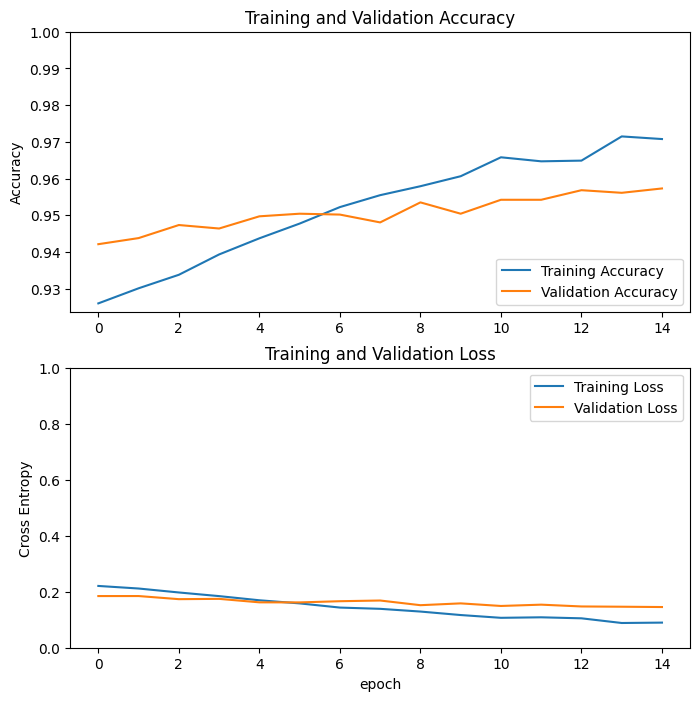

In [43]:
loss_VVST, accuracy_VVST = model_VVST.evaluate(test_dataset)
acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST = loadHistory('VVSTvgg16Animals')
distplayHistory(acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST)

MOBILENET NO TRANSFER

In [13]:
preprocess_input_MNT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MNT= IMG_SIZE + (3,)
mobilenet_model_MNT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MNT,
                                               include_top=False)
image_batch_MNT, label_batch_MNT= next(iter(train_dataset))
feature_batch_MNT= mobilenet_model_MNT(image_batch_MNT)

global_average_layer_MNT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MNT= global_average_layer_MNT(feature_batch_MNT)

fc1_layer_MNT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MNT= fc1_layer_MNT(feature_batch_average_MNT)

prediction_layer_MNT= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_MNT= prediction_layer_MNT(fc1_batch_MNT)

inputs_MNT= tf.keras.Input(shape=(160, 160, 3))
x_MNT= preprocess_input_MNT(inputs_MNT)
x_MNT= mobilenet_model_MNT(x_MNT)
x_MNT= global_average_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
x_MNT= fc1_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
outputs_MNT= prediction_layer_MNT(x_MNT)
model_MNT= tf.keras.Model(inputs_MNT, outputs_MNT)
model_MNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MNT= "training_models/Animals_MNT.ckpt"
checkpoint_dir_MNT= os.path.dirname(checkpoint_path_MNT)
cp_callback_MNT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [37]:
total_epochs_MNT = 10
history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT])
initial_epochs_MNT=total_epochs_MNT
dumpHistory('MNTmobnetAnimals', history_MNT)

Epoch 1/10
328/328 [==============================] - 216s 645ms/step - loss: 0.6567 - accuracy: 0.7945 - val_loss: 0.2437 - val_accuracy: 0.9274
Epoch 2/10
328/328 [==============================] - 233s 709ms/step - loss: 0.2528 - accuracy: 0.9215 - val_loss: 0.1795 - val_accuracy: 0.9445
Epoch 3/10
328/328 [==============================] - 206s 627ms/step - loss: 0.1868 - accuracy: 0.9434 - val_loss: 0.1529 - val_accuracy: 0.9488
Epoch 4/10
328/328 [==============================] - 208s 632ms/step - loss: 0.1452 - accuracy: 0.9563 - val_loss: 0.1431 - val_accuracy: 0.9535
Epoch 5/10
328/328 [==============================] - 232s 706ms/step - loss: 0.1212 - accuracy: 0.9638 - val_loss: 0.1382 - val_accuracy: 0.9568
Epoch 6/10
328/328 [==============================] - 210s 637ms/step - loss: 0.1001 - accuracy: 0.9708 - val_loss: 0.1414 - val_accuracy: 0.9540
Epoch 7/10
328/328 [==============================] - 207s 629ms/step - loss: 0.0864 - accuracy: 0.9740 - val_loss: 0.1285 -

In [38]:
model_MNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MNT = 10
total_epochs_MNT =  initial_epochs_MNT + add_epochs_MNT

history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=initial_epochs_MNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT, clr])
initial_epochs_MNT+=add_epochs_MNT
dumpHistory('MNTmobnetAnimals', history_MNT)

Epoch 11/20
328/328 [==============================] - 223s 666ms/step - loss: 0.0470 - accuracy: 0.9879 - val_loss: 0.1219 - val_accuracy: 0.9640
Epoch 12/20
328/328 [==============================] - 237s 720ms/step - loss: 0.0468 - accuracy: 0.9866 - val_loss: 0.1223 - val_accuracy: 0.9654
Epoch 13/20
328/328 [==============================] - 235s 714ms/step - loss: 0.0427 - accuracy: 0.9890 - val_loss: 0.1222 - val_accuracy: 0.9651
Epoch 14/20
328/328 [==============================] - 234s 714ms/step - loss: 0.0431 - accuracy: 0.9886 - val_loss: 0.1213 - val_accuracy: 0.9644
Epoch 15/20
328/328 [==============================] - 234s 713ms/step - loss: 0.0445 - accuracy: 0.9887 - val_loss: 0.1247 - val_accuracy: 0.9628
Epoch 16/20
328/328 [==============================] - 234s 712ms/step - loss: 0.0429 - accuracy: 0.9887 - val_loss: 0.1241 - val_accuracy: 0.9644
Epoch 17/20
328/328 [==============================] - 234s 712ms/step - loss: 0.0427 - accuracy: 0.9892 - val_loss: 0

16/16 [==============================] - 4s 240ms/step - loss: 0.1037 - accuracy: 0.9648


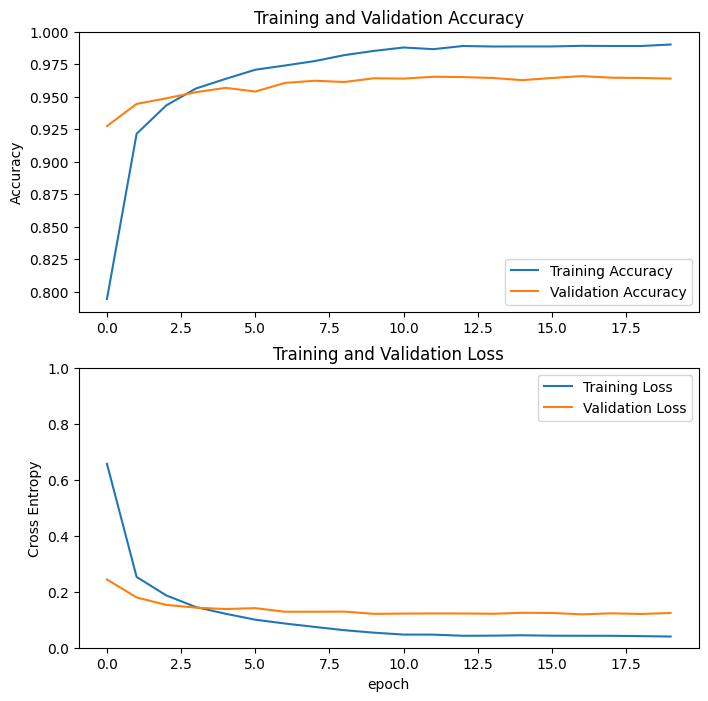

In [17]:
model_MNT.load_weights("training_models/Animals_MNT.ckpt")
loss_MNT, accuracy_MNT = model_MNT.evaluate(test_dataset)
acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT = loadHistory('MNTmobnetAnimals')
distplayHistory(acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT)

MOBILENET FAST TRANSFER

In [19]:
preprocess_input_MFT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MFT= IMG_SIZE + (3,)
mobilenet_model_MFT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MFT,
                                               include_top=False)
mobilenet_model_MFT.trainable = False
image_batch_MFT, label_batch_MFT= next(iter(train_dataset))
feature_batch_MFT= mobilenet_model_MFT(image_batch_MFT)

global_average_layer_MFT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MFT= global_average_layer_MFT(feature_batch_MFT)

fc1_layer_MFT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MFT= fc1_layer_MFT(feature_batch_average_MFT)

prediction_layer_MFT= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_MFT= prediction_layer_MFT(fc1_batch_MFT)

inputs_MFT= tf.keras.Input(shape=(160, 160, 3))
x_MFT= preprocess_input_MFT(inputs_MFT)
x_MFT= mobilenet_model_MFT(x_MFT)
x_MFT= global_average_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
x_MFT= fc1_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
outputs_MFT= prediction_layer_MFT(x_MFT)
model_MFT= tf.keras.Model(inputs_MFT, outputs_MFT)
model_MFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MFT= "training_models/Animals_MFT.ckpt"
checkpoint_dir_MFT= os.path.dirname(checkpoint_path_MFT)
cp_callback_MFT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [13]:
print("Number of layers in the base model: ", len(mobilenet_model_MFT.layers))

Number of layers in the base model:  86


In [19]:
total_epochs_MFT = 5
history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
initial_epochs_MFT=total_epochs_MFT
dumpHistory('MFTmobnetAnimals', history_MFT)

Epoch 1/5
328/328 [==============================] - 92s 270ms/step - loss: 0.7491 - accuracy: 0.7712 - val_loss: 0.2875 - val_accuracy: 0.9194
Epoch 2/5
328/328 [==============================] - 86s 263ms/step - loss: 0.3235 - accuracy: 0.8989 - val_loss: 0.2241 - val_accuracy: 0.9312
Epoch 3/5
328/328 [==============================] - 86s 263ms/step - loss: 0.2659 - accuracy: 0.9181 - val_loss: 0.1975 - val_accuracy: 0.9405
Epoch 4/5
328/328 [==============================] - 86s 262ms/step - loss: 0.2389 - accuracy: 0.9240 - val_loss: 0.1765 - val_accuracy: 0.9459
Epoch 5/5
328/328 [==============================] - 86s 263ms/step - loss: 0.2164 - accuracy: 0.9319 - val_loss: 0.1691 - val_accuracy: 0.9469


In [20]:
mobilenet_model_MFT.trainable = True
fine_tune_at_MFT = 72
for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
  layer_MFT.trainable = False
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MFT = 1
total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
dumpHistory('MFTmobnetAnimals', history_MFT)
initial_epochs_MFT += fine_tune_epochs_MFT
for i in range (4):
  mobilenet_model_MFT.trainable = True
  fine_tune_at_MFT -= 18
  for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
    layer_MFT.trainable = False
  model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MFT = 1
  total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT


  history_MFT = model_MFT.fit(train_dataset,
                          epochs=total_epochs_MFT,
                          initial_epoch=initial_epochs_MFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_MFT])
  dumpHistory('MFTmobnetAnimals', history_MFT)
  initial_epochs_MFT+=fine_tune_epochs_MFT


Epoch 6/6
328/328 [==============================] - 100s 296ms/step - loss: 0.2525 - accuracy: 0.9200 - val_loss: 0.1802 - val_accuracy: 0.9462
Epoch 7/7
328/328 [==============================] - 116s 347ms/step - loss: 0.2563 - accuracy: 0.9194 - val_loss: 0.1836 - val_accuracy: 0.9419
Epoch 8/8
328/328 [==============================] - 132s 395ms/step - loss: 0.2490 - accuracy: 0.9212 - val_loss: 0.1831 - val_accuracy: 0.9429
Epoch 9/9
328/328 [==============================] - 168s 503ms/step - loss: 0.2410 - accuracy: 0.9233 - val_loss: 0.1773 - val_accuracy: 0.9450
Epoch 10/10
328/328 [==============================] - 224s 672ms/step - loss: 0.2290 - accuracy: 0.9272 - val_loss: 0.1727 - val_accuracy: 0.9478


In [21]:
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MFT = 10
total_epochs_MFT =  initial_epochs_MFT + add_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT, clr])
initial_epochs_MFT+=add_epochs_MFT
dumpHistory('MFTmobnetAnimals', history_MFT)

Epoch 11/20
328/328 [==============================] - 223s 673ms/step - loss: 0.2212 - accuracy: 0.9283 - val_loss: 0.1719 - val_accuracy: 0.9457
Epoch 12/20
328/328 [==============================] - 216s 658ms/step - loss: 0.2148 - accuracy: 0.9320 - val_loss: 0.1643 - val_accuracy: 0.9500
Epoch 13/20
328/328 [==============================] - 222s 675ms/step - loss: 0.2070 - accuracy: 0.9333 - val_loss: 0.1611 - val_accuracy: 0.9497
Epoch 14/20
328/328 [==============================] - 221s 674ms/step - loss: 0.2003 - accuracy: 0.9382 - val_loss: 0.1581 - val_accuracy: 0.9514
Epoch 15/20
328/328 [==============================] - 222s 675ms/step - loss: 0.1911 - accuracy: 0.9392 - val_loss: 0.1608 - val_accuracy: 0.9502
Epoch 16/20
328/328 [==============================] - 221s 674ms/step - loss: 0.1857 - accuracy: 0.9420 - val_loss: 0.1517 - val_accuracy: 0.9530
Epoch 17/20
328/328 [==============================] - 221s 674ms/step - loss: 0.1837 - accuracy: 0.9420 - val_loss: 0

16/16 [==============================] - 4s 218ms/step - loss: 0.1343 - accuracy: 0.9600


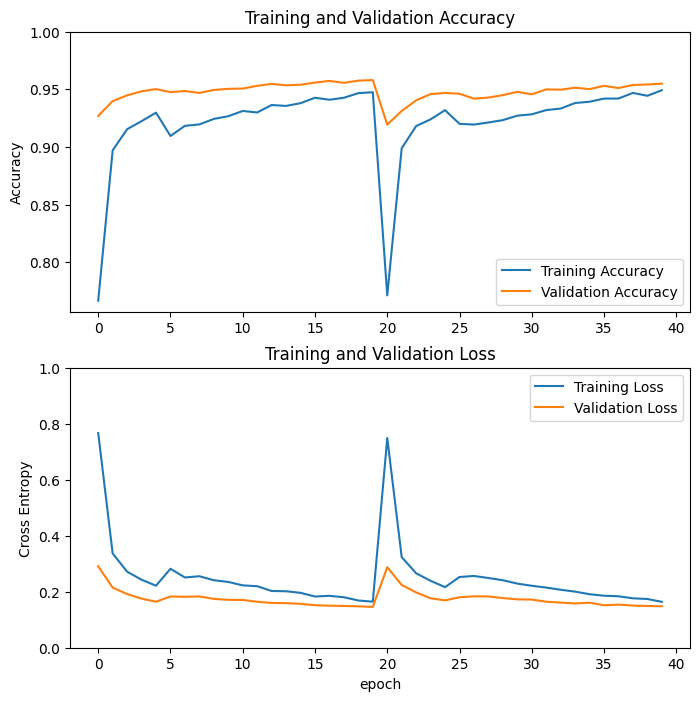

In [22]:
loss_MFT, accuracy_MFT = model_MFT.evaluate(test_dataset)
acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT = loadHistory('MFTmobnetAnimals')
distplayHistory(acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT)

MOBILENET SLOW TRANSFER

In [20]:
preprocess_input_MST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MST= IMG_SIZE + (3,)
mobilenet_model_MST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MST,
                                               include_top=False)
mobilenet_model_MST.trainable = False
image_batch_MST, label_batch_MST= next(iter(train_dataset))
feature_batch_MST= mobilenet_model_MST(image_batch_MST)

global_average_layer_MST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MST= global_average_layer_MST(feature_batch_MST)

fc1_layer_MST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MST= fc1_layer_MST(feature_batch_average_MST)

prediction_layer_MST= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_MST= prediction_layer_MST(fc1_batch_MST)

inputs_MST= tf.keras.Input(shape=(160, 160, 3))
x_MST= preprocess_input_MST(inputs_MST)
x_MST= mobilenet_model_MST(x_MST)
x_MST= global_average_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
x_MST= fc1_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
outputs_MST= prediction_layer_MST(x_MST)
model_MST= tf.keras.Model(inputs_MST, outputs_MST)
model_MST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MST= "training_models/Animals_MST.ckpt"
checkpoint_dir_MST= os.path.dirname(checkpoint_path_MST)
cp_callback_MST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [24]:
total_epochs_MST = 10
history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
initial_epochs_MST=total_epochs_MST
dumpHistory('MSTmobnetAnimals', history_MST)

Epoch 1/10
328/328 [==============================] - 89s 266ms/step - loss: 0.7613 - accuracy: 0.7638 - val_loss: 0.2955 - val_accuracy: 0.9196
Epoch 2/10
328/328 [==============================] - 87s 265ms/step - loss: 0.3328 - accuracy: 0.8961 - val_loss: 0.2199 - val_accuracy: 0.9322
Epoch 3/10
328/328 [==============================] - 87s 264ms/step - loss: 0.2650 - accuracy: 0.9173 - val_loss: 0.1932 - val_accuracy: 0.9412
Epoch 4/10
328/328 [==============================] - 87s 264ms/step - loss: 0.2371 - accuracy: 0.9258 - val_loss: 0.1825 - val_accuracy: 0.9417
Epoch 5/10
328/328 [==============================] - 87s 265ms/step - loss: 0.2205 - accuracy: 0.9308 - val_loss: 0.1714 - val_accuracy: 0.9438
Epoch 6/10
328/328 [==============================] - 87s 265ms/step - loss: 0.2066 - accuracy: 0.9336 - val_loss: 0.1685 - val_accuracy: 0.9450
Epoch 7/10
328/328 [==============================] - 87s 264ms/step - loss: 0.1956 - accuracy: 0.9369 - val_loss: 0.1688 - val_ac

In [25]:
mobilenet_model_MST.trainable = True
fine_tune_at_MST = 72
for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
  layer_MST.trainable = False
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MST = 2
total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
dumpHistory('MSTmobnetAnimals', history_MST)
initial_epochs_MST += fine_tune_epochs_MST
print(len(model_MST.trainable_variables))
for i in range (4):
  mobilenet_model_MST.trainable = True
  fine_tune_at_MST -= 18
  for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
    layer_MST.trainable = False
  model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MST = 2
  total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST


  history_MST = model_MST.fit(train_dataset,
                          epochs=total_epochs_MST,
                          initial_epoch=initial_epochs_MST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MST])
  dumpHistory('MSTmobnetAnimals', history_MST)
  initial_epochs_MST+=fine_tune_epochs_MST


Epoch 11/12
328/328 [==============================] - 100s 299ms/step - loss: 0.2143 - accuracy: 0.9322 - val_loss: 0.1638 - val_accuracy: 0.9476
Epoch 12/12
328/328 [==============================] - 98s 297ms/step - loss: 0.2045 - accuracy: 0.9343 - val_loss: 0.1594 - val_accuracy: 0.9485
16
Epoch 13/14
328/328 [==============================] - 117s 349ms/step - loss: 0.2157 - accuracy: 0.9304 - val_loss: 0.1645 - val_accuracy: 0.9452
Epoch 14/14
328/328 [==============================] - 114s 347ms/step - loss: 0.2068 - accuracy: 0.9341 - val_loss: 0.1670 - val_accuracy: 0.9462
Epoch 15/16
328/328 [==============================] - 133s 398ms/step - loss: 0.2092 - accuracy: 0.9336 - val_loss: 0.1626 - val_accuracy: 0.9474
Epoch 16/16
328/328 [==============================] - 130s 397ms/step - loss: 0.1999 - accuracy: 0.9355 - val_loss: 0.1595 - val_accuracy: 0.9497
Epoch 17/18
328/328 [==============================] - 167s 503ms/step - loss: 0.1973 - accuracy: 0.9378 - val_loss:

In [26]:
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MST = 5
total_epochs_MST =  initial_epochs_MST + add_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST, clr])
initial_epochs_MST+=add_epochs_MST
dumpHistory('MSTmobnetAnimals', history_MST)

Epoch 21/25
328/328 [==============================] - 225s 678ms/step - loss: 0.1673 - accuracy: 0.9458 - val_loss: 0.1485 - val_accuracy: 0.9516
Epoch 22/25
328/328 [==============================] - 222s 676ms/step - loss: 0.1702 - accuracy: 0.9454 - val_loss: 0.1485 - val_accuracy: 0.9521
Epoch 23/25
328/328 [==============================] - 222s 676ms/step - loss: 0.1590 - accuracy: 0.9493 - val_loss: 0.1493 - val_accuracy: 0.9519
Epoch 24/25
328/328 [==============================] - 222s 676ms/step - loss: 0.1576 - accuracy: 0.9489 - val_loss: 0.1496 - val_accuracy: 0.9533
Epoch 25/25
328/328 [==============================] - 222s 676ms/step - loss: 0.1557 - accuracy: 0.9508 - val_loss: 0.1417 - val_accuracy: 0.9542


16/16 [==============================] - 4s 218ms/step - loss: 0.1264 - accuracy: 0.9629


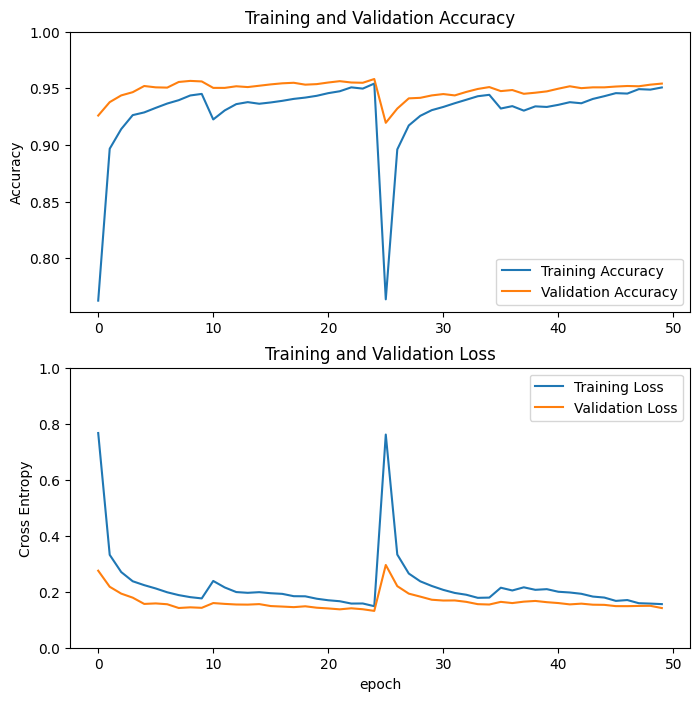

In [27]:
loss_MST, accuracy_MST = model_MST.evaluate(test_dataset)
acc_MST, val_acc_MST, loss_MST, val_loss_MST = loadHistory('MSTmobnetAnimals')
distplayHistory(acc_MST, val_acc_MST, loss_MST, val_loss_MST)

MOBILE NET PARTICAL TRANSFER

In [28]:
preprocess_input_MPT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MPT= IMG_SIZE + (3,)
mobilenet_model_MPT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MPT,
                                               include_top=False)
mobilenet_model_MPT.trainable = False
image_batch_MPT, label_batch_MPT= next(iter(train_dataset))
feature_batch_MPT= mobilenet_model_MPT(image_batch_MPT)

global_average_layer_MPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MPT= global_average_layer_MPT(feature_batch_MPT)

fc1_layer_MPT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MPT= fc1_layer_MPT(feature_batch_average_MPT)

prediction_layer_MPT= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_MPT= prediction_layer_MPT(fc1_batch_MPT)

inputs_MPT= tf.keras.Input(shape=(160, 160, 3))
x_MPT= preprocess_input_MPT(inputs_MPT)
x_MPT= mobilenet_model_MPT(x_MPT)
x_MPT= global_average_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
x_MPT= fc1_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
outputs_MPT= prediction_layer_MPT(x_MPT)
model_MPT= tf.keras.Model(inputs_MPT, outputs_MPT)
model_MPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MPT= "training_models/Animals_MPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [29]:
total_epochs_MPT = 20
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetAnimals', history_MPT)

Epoch 1/20
328/328 [==============================] - 89s 265ms/step - loss: 0.7985 - accuracy: 0.7516 - val_loss: 0.2862 - val_accuracy: 0.9253
Epoch 2/20
328/328 [==============================] - 87s 264ms/step - loss: 0.3289 - accuracy: 0.8992 - val_loss: 0.2149 - val_accuracy: 0.9381
Epoch 3/20
328/328 [==============================] - 87s 264ms/step - loss: 0.2731 - accuracy: 0.9148 - val_loss: 0.1953 - val_accuracy: 0.9426
Epoch 4/20
328/328 [==============================] - 87s 264ms/step - loss: 0.2412 - accuracy: 0.9251 - val_loss: 0.1801 - val_accuracy: 0.9433
Epoch 5/20
328/328 [==============================] - 87s 264ms/step - loss: 0.2282 - accuracy: 0.9275 - val_loss: 0.1673 - val_accuracy: 0.9500
Epoch 6/20
328/328 [==============================] - 87s 264ms/step - loss: 0.2085 - accuracy: 0.9346 - val_loss: 0.1676 - val_accuracy: 0.9476
Epoch 7/20
328/328 [==============================] - 87s 264ms/step - loss: 0.1969 - accuracy: 0.9389 - val_loss: 0.1637 - val_ac

In [30]:
checkpoint_path_MPT= "training_models/Animals_MFPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_MPT = 40
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT, clr])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetAnimals', history_MPT)

Epoch 1/40
328/328 [==============================] - 87s 266ms/step - loss: 0.1337 - accuracy: 0.9562 - val_loss: 0.1349 - val_accuracy: 0.9564
Epoch 2/40
328/328 [==============================] - 88s 266ms/step - loss: 0.1356 - accuracy: 0.9574 - val_loss: 0.1346 - val_accuracy: 0.9568
Epoch 3/40
328/328 [==============================] - 88s 266ms/step - loss: 0.1347 - accuracy: 0.9566 - val_loss: 0.1385 - val_accuracy: 0.9559
Epoch 4/40
328/328 [==============================] - 88s 266ms/step - loss: 0.1351 - accuracy: 0.9569 - val_loss: 0.1401 - val_accuracy: 0.9566
Epoch 5/40
328/328 [==============================] - 88s 266ms/step - loss: 0.1339 - accuracy: 0.9584 - val_loss: 0.1359 - val_accuracy: 0.9571
Epoch 6/40
328/328 [==============================] - 88s 266ms/step - loss: 0.1344 - accuracy: 0.9571 - val_loss: 0.1348 - val_accuracy: 0.9566
Epoch 7/40
328/328 [==============================] - 88s 267ms/step - loss: 0.1340 - accuracy: 0.9572 - val_loss: 0.1367 - val_ac

16/16 [==============================] - 4s 215ms/step - loss: 0.1263 - accuracy: 0.9678


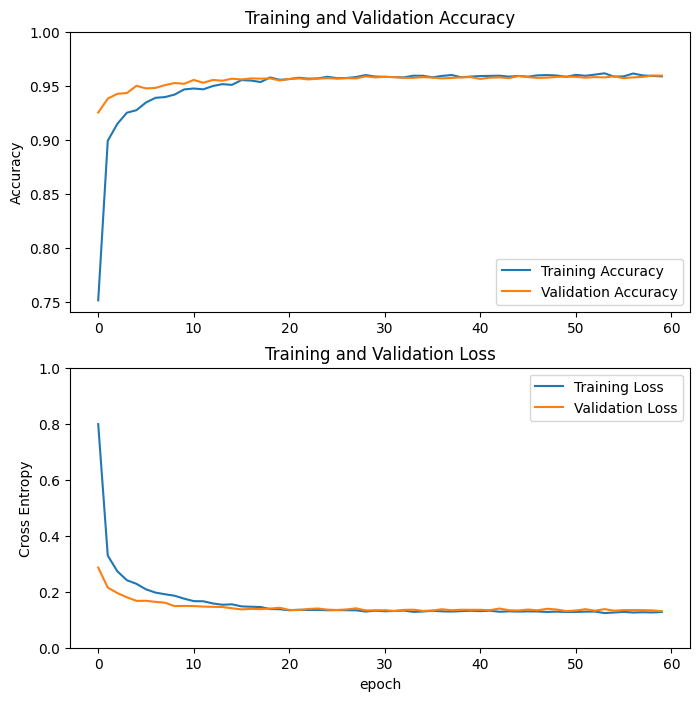

In [31]:
loss_MPT, accuracy_MPT = model_MPT.evaluate(test_dataset)
acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT = loadHistory('MPTmobnetAnimals')
distplayHistory(acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT)

MOBILE NET VERY SLOW TRANSFER

In [32]:
preprocess_input_MVST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MVST= IMG_SIZE + (3,)
mobilenet_model_MVST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MVST,
                                               include_top=False)
mobilenet_model_MVST.trainable = False
image_batch_MVST, label_batch_MVST= next(iter(train_dataset))
feature_batch_MVST= mobilenet_model_MVST(image_batch_MVST)

global_average_layer_MVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MVST= global_average_layer_MVST(feature_batch_MVST)

fc1_layer_MVST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MVST= fc1_layer_MVST(feature_batch_average_MVST)

prediction_layer_MVST= tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
prediction_batch_MVST= prediction_layer_MVST(fc1_batch_MVST)

inputs_MVST= tf.keras.Input(shape=(160, 160, 3))
x_MVST= preprocess_input_MVST(inputs_MVST)
x_MVST= mobilenet_model_MVST(x_MVST)
x_MVST= global_average_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
x_MVST= fc1_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
outputs_MVST= prediction_layer_MVST(x_MVST)
model_MVST= tf.keras.Model(inputs_MVST, outputs_MVST)
model_MVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MVST= "training_models/Animals_MVST.ckpt"
checkpoint_dir_MVST= os.path.dirname(checkpoint_path_MVST)
cp_callback_MVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [34]:
model_MVST.load_weights("training_models/Animals_MPT.ckpt")
mobilenet_model_MVST.trainable = True
initial_epochs_MVST=20
fine_tune_at_MVST = 72
for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
  layer_MVST.trainable = False
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MVST = 1
total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST])
dumpHistory('MVSTmobnetAnimals', history_MVST)
initial_epochs_MVST += fine_tune_epochs_MVST
for i in range (9):
  mobilenet_model_MVST.trainable = True
  fine_tune_at_MVST -= 8
  for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
    layer_MVST.trainable = False
  model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MVST = 1
  total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST


  history_MVST = model_MVST.fit(train_dataset,
                          epochs=total_epochs_MVST,
                          initial_epoch=initial_epochs_MVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MVST])
  dumpHistory('MVSTmobnetAnimals', history_MVST)
  initial_epochs_MVST+=fine_tune_epochs_MVST


Epoch 21/21
328/328 [==============================] - 110s 328ms/step - loss: 0.1854 - accuracy: 0.9409 - val_loss: 0.1462 - val_accuracy: 0.9559
Epoch 22/22
328/328 [==============================] - 119s 353ms/step - loss: 0.1840 - accuracy: 0.9408 - val_loss: 0.1527 - val_accuracy: 0.9533
Epoch 23/23
328/328 [==============================] - 114s 340ms/step - loss: 0.1758 - accuracy: 0.9444 - val_loss: 0.1501 - val_accuracy: 0.9554
Epoch 24/24
328/328 [==============================] - 131s 392ms/step - loss: 0.1672 - accuracy: 0.9463 - val_loss: 0.1475 - val_accuracy: 0.9530
Epoch 25/25
328/328 [==============================] - 141s 422ms/step - loss: 0.1750 - accuracy: 0.9438 - val_loss: 0.1482 - val_accuracy: 0.9549
Epoch 26/26
328/328 [==============================] - 145s 434ms/step - loss: 0.1690 - accuracy: 0.9441 - val_loss: 0.1473 - val_accuracy: 0.9535
Epoch 27/27
328/328 [==============================] - 160s 479ms/step - loss: 0.1602 - accuracy: 0.9480 - val_loss: 0

In [35]:
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MVST = 5
total_epochs_MVST =  initial_epochs_MVST + add_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST, clr])
initial_epochs_MVST+=add_epochs_MVST
dumpHistory('MVSTmobnetAnimals', history_MVST)

Epoch 31/35
328/328 [==============================] - 239s 719ms/step - loss: 0.1494 - accuracy: 0.9517 - val_loss: 0.1365 - val_accuracy: 0.9566
Epoch 32/35
328/328 [==============================] - 226s 687ms/step - loss: 0.1400 - accuracy: 0.9551 - val_loss: 0.1364 - val_accuracy: 0.9585
Epoch 33/35
328/328 [==============================] - 225s 686ms/step - loss: 0.1373 - accuracy: 0.9554 - val_loss: 0.1347 - val_accuracy: 0.9580
Epoch 34/35
328/328 [==============================] - 233s 710ms/step - loss: 0.1343 - accuracy: 0.9568 - val_loss: 0.1373 - val_accuracy: 0.9573
Epoch 35/35
328/328 [==============================] - 235s 715ms/step - loss: 0.1307 - accuracy: 0.9584 - val_loss: 0.1353 - val_accuracy: 0.9594


16/16 [==============================] - 4s 235ms/step - loss: 0.1507 - accuracy: 0.9600


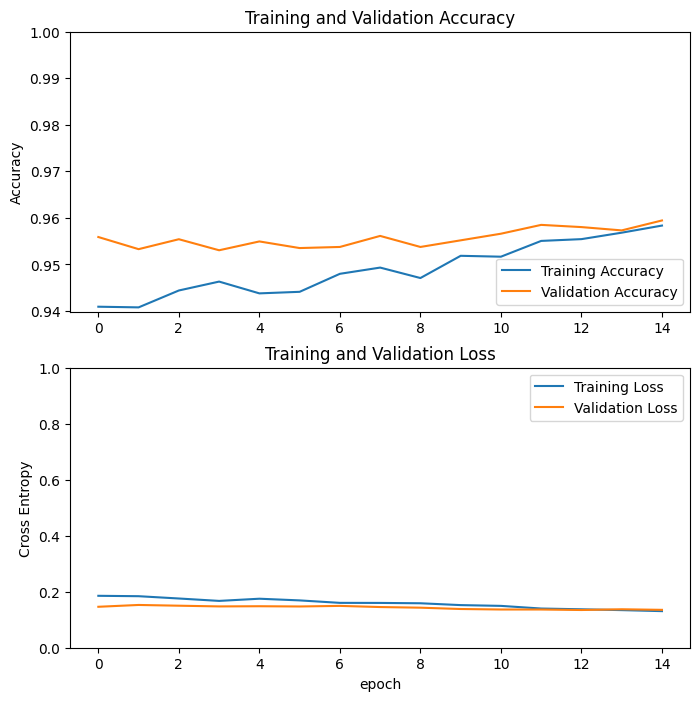

In [36]:
loss_MVST, accuracy_MVST = model_MVST.evaluate(test_dataset)
acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST = loadHistory('MVSTmobnetAnimals')
distplayHistory(acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST)